# Content
* [1 - One Hot Encoding](#1) 
* [2 - One Hot Encoding of Frequent Categories](#2) 
* [3 - Label Encoding](#3)
* [4 - Count or frequency encoding](#4)
* [5 - Target guided encodings](#5)
* [6 - Mean Encoding](#6)
* [7 - Probability-Ratio-Encoding](#7)
* [8 - Weight of Evidence](#8)
* [9 - Comparison of Categorical Variable Encodings](#9)
* [10 - Engineering Rare Categories](#10)


<hr/>

<a id = "1"></a><br>
# 1 - One Hot Encoding

One hot encoding, consists in encoding each categorical variable with different boolean variables (also called dummy variables) which take values 0 or 1, indicating if a category is present in an observation.

For example, for the categorical variable "Gender", with labels 'female' and 'male', we can generate the boolean variable "female", which takes 1 if the person is 'female' or 0 otherwise, or we can generate the variable "male", which takes 1 if the person is 'male' and 0 otherwise.

For the categorical variable "colour" with values 'red', 'blue' and 'green', we can create 3 new variables called "red", "blue" and "green". These variables will take the value 1, if the observation is of the said colour or 0 otherwise. 


### Encoding into k-1 dummy variables

Note however, that for the variable "colour", by creating 2 binary variables, say "red" and "blue", we already encode **ALL** the information:

- if the observation is red, it will be captured by the variable "red" (red = 1, blue = 0)
- if the observation is blue, it will be captured by the variable "blue" (red = 0, blue = 1)
- if the observation is green, it will be captured by the combination of "red" and "blue" (red = 0, blue = 0)

We do not need to add a third variable "green" to capture that the observation is green.

More generally, a categorical variable should be encoded by creating k-1 binary variables, where k is the number of distinct categories. In the case of gender, k=2 (male / female), therefore we need to create only 1 (k - 1 = 1) binary variable. In the case of colour, which has 3 different categories (k=3), we need to create 2 (k - 1 = 2) binary variables to capture all the information.

One hot encoding into k-1 binary variables takes into account that we can use 1 less dimension and still represent the whole information: if the observation is 0 in all the binary variables, then it must be 1 in the final (not present) binary variable.

**When one hot encoding categorical variables, we create k - 1 binary variables**


Most machine learning algorithms, consider the entire data set while being fit. Therefore, encoding categorical variables into k - 1 binary variables, is better, as it avoids introducing redundant information.


### Exception: One hot encoding into k dummy variables

There are a few occasions when it is better to encode variables into k dummy variables:

- when building tree based algorithms
- when doing feature selection by recursive algorithms
- when interested in determine the importance of each single category

Tree based algorithms, as opposed to the majority of machine learning algorithms, **do not** evaluate the entire dataset while being trained. They randomly extract a subset of features from the data set at each node for each tree. Therefore, if we want a tree based algorithm to consider **all** the categories, we need to encode categorical variables into **k binary variables**.

If we are planning to do feature selection by recursive elimination (or addition), or if we want to evaluate the importance of each single category of the categorical variable, then we will also need the entire set of binary variables (k) to let the machine learning model select which ones have the most predictive power.


### Advantages of one hot encoding

- Straightforward to implement
- Makes no assumption about the distribution or categories of the categorical variable
- Keeps all the information of the categorical variable
- Suitable for linear models

### Limitations

- Expands the feature space
- Does not add extra information while encoding
- Many dummy variables may be identical, introducing redundant information


### Notes

If our datasets contain a few highly cardinal variables, we will end up very soon with datasets with thousands of columns, which may make training of our algorithms slow, and model interpretation hard.

In addition, many of these dummy variables may be similar to each other, since it is not unusual that 2 or more variables share the same combinations of 1 and 0s. Therefore one hot encoding may introduce redundant or duplicated information even if we encode into k-1.


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Scikit-learn
- Feature-Engine

And the advantages and limitations of each implementation using the Titanic dataset.

In [24]:
import pandas as pd

# to split the datasets
from sklearn.model_selection import train_test_split

# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder

# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

#
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load titanic dataset

data = pd.read_csv('titanic.csv',
                   usecols=['sex', 'embarked', 'cabin', 'survived'])
data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [3]:
# let's capture only the first letter of the 
# cabin for this demonstration

data['cabin'] = data['cabin'].str[0]

data.head()

,survived,sex,cabin,embarked
0,1,female,B,S
1,1,male,C,S
2,0,female,C,S
3,0,male,C,S
4,0,female,C,S


### Encoding important

Just like imputation, all methods of categorical encoding should be performed over the training set, and then propagated to the test set. 

Why? 

Because these methods will "learn" patterns from the train data, and therefore you want to avoid leaking information and overfitting. But more importantly, because we don't know whether in future / live data, we will have all the categories present in the train data, or if there will be more or less categories. Therefore, we want to anticipate this uncertainty by setting the right processes right from the start. We want to create transformers that learn the categories from the train set, and used those learned categories to create the dummy variables in both train and test sets.

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['sex', 'embarked', 'cabin']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 3), (393, 3))

### Let's explore the cardinality

In [5]:
# sex has 2 labels

X_train['sex'].unique()

array(['female', 'male'], dtype=object)

In [6]:
# embarked has 3 labels and missing data

X_train['embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [7]:
# cabin has 9 labels and missing data

X_train['cabin'].unique()

array([nan, 'E', 'C', 'D', 'B', 'A', 'F', 'T', 'G'], dtype=object)

## One hot encoding with pandas

### Advantages

- quick
- returns pandas dataframe
- returns feature names for the dummy variables

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data


-----

The pandas method get_dummies(), will create as many binary variables as categories in the variable:

If the variable colour has 3 categories in the train data, it will create 2 dummy variables. However, if the variable colour has 5 categories in the test data, it will create 4 binary variables, therefore train and test sets will end up with different number of features and will be incompatible with training and scoring using Scikit-learn.

In practice, we shouldn't be using get-dummies in our machine learning pipelines. It is however useful, for a quick data exploration. Let's look at this with examples.

### into k  dummy variables

In [8]:
# we can create dummy variables with the build in
# pandas method get_dummies

tmp = pd.get_dummies(X_train['sex'])

tmp.head()

,female,male
501,1,0
588,1,0
402,1,0
1193,0,1
686,1,0


In [9]:
# for better visualisation let's put the dummies next
# to the original variable

pd.concat([X_train['sex'],
           pd.get_dummies(X_train['sex'])], axis=1).head()

,sex,female,male
501,female,1,0
588,female,1,0
402,female,1,0
1193,male,0,1
686,female,1,0


In [10]:
# and now let's repeat for embarked

tmp = pd.get_dummies(X_train['embarked'])

tmp.head()

,C,Q,S
501,0,0,1
588,0,0,1
402,1,0,0
1193,0,1,0
686,0,1,0


In [11]:
# for better visualisation

pd.concat([X_train['embarked'],
           pd.get_dummies(X_train['embarked'])], axis=1).head()

,embarked,C,Q,S
501,S,0,0,1
588,S,0,0,1
402,C,1,0,0
1193,Q,0,1,0
686,Q,0,1,0


In [12]:
# and now for cabin

tmp = pd.get_dummies(X_train['cabin'])

tmp.head()

,A,B,C,D,E,F,G,T
501,0,0,0,0,0,0,0,0
588,0,0,0,0,0,0,0,0
402,0,0,0,0,0,0,0,0
1193,0,0,0,0,0,0,0,0
686,0,0,0,0,0,0,0,0


In [13]:
# and now for all variables together: train set

tmp = pd.get_dummies(X_train)

print(tmp.shape)

tmp.head()

(916, 13)


,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T
501,1,0,0,0,1,0,0,0,0,0,0,0,0
588,1,0,0,0,1,0,0,0,0,0,0,0,0
402,1,0,1,0,0,0,0,0,0,0,0,0,0
1193,0,1,0,1,0,0,0,0,0,0,0,0,0
686,1,0,0,1,0,0,0,0,0,0,0,0,0


In [14]:
# and now for all variables together: test set

tmp = pd.get_dummies(X_test)

print(tmp.shape)

tmp.head()

(393, 12)


,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G
1139,0,1,0,0,1,0,0,0,0,0,0,0
533,1,0,0,0,1,0,0,0,0,0,0,0
459,0,1,0,0,1,0,0,0,0,0,0,0
1150,0,1,0,0,1,0,0,0,0,0,0,0
393,0,1,0,0,1,0,0,0,0,0,0,0


Notice the positives of pandas get_dummies:
- dataframe returned with feature names

**And the limitations:**

The train set contains 13 dummy features, whereas the test set contains 12 features. This occurred because there was no category T in cabin in the test set.

This will cause problems if training and scoring models with scikit-learn, because predictors require train and test sets to be of the same shape.

### into k -1 

In [15]:
# obtaining k-1 labels: we need to indicate get_dummies
# to drop the first binary variable

tmp = pd.get_dummies(X_train['sex'], drop_first=True)

tmp.head()

,male
501,0
588,0
402,0
1193,1
686,0


In [16]:
# obtaining k-1 labels: we need to indicate get_dummies
# to drop the first binary variable

tmp = pd.get_dummies(X_train['embarked'], drop_first=True)

tmp.head()

,Q,S
501,0,1
588,0,1
402,0,0
1193,1,0
686,1,0


For embarked, if an observation shows 0 for Q and S, then its value must be C, the remaining category.

Caveat, this variable has missing data, so unless we encode missing data as well, all the information contained in the variable is not captured.

In [17]:
# altogether: train set

tmp = pd.get_dummies(X_train, drop_first=True)

print(tmp.shape)

tmp.head()

(916, 10)


,sex_male,embarked_Q,embarked_S,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_T
501,0,0,1,0,0,0,0,0,0,0
588,0,0,1,0,0,0,0,0,0,0
402,0,0,0,0,0,0,0,0,0,0
1193,1,1,0,0,0,0,0,0,0,0
686,0,1,0,0,0,0,0,0,0,0


In [18]:
# altogether: test set

tmp = pd.get_dummies(X_test, drop_first=True)

print(tmp.shape)

tmp.head()

(393, 9)


,sex_male,embarked_Q,embarked_S,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G
1139,1,0,1,0,0,0,0,0,0
533,0,0,1,0,0,0,0,0,0
459,1,0,1,0,0,0,0,0,0
1150,1,0,1,0,0,0,0,0,0
393,1,0,1,0,0,0,0,0,0


### Bonus: get_dummies() can handle missing values

In [19]:
# we can add an additional dummy variable to indicate
# missing data

pd.get_dummies(X_train['embarked'], drop_first=True, dummy_na=True).head()

,Q,S,NaN
501,0,1,0
588,0,1,0
402,0,0,0
1193,1,0,0
686,1,0,0


## One hot encoding with Scikit-learn

### Advantages

- quick
- Creates the same number of features in train and test set

### Limitations

- it returns a numpy array instead of a pandas dataframe
- it does not return the variable names, therefore inconvenient for variable exploration

In [17]:
# we create and train the encoder

encoder = OneHotEncoder(categories='auto',
                       drop='first', # to return k-1, use drop=false to return k dummies
                       sparse=False,
                       handle_unknown='error') # helps deal with rare labels

encoder.fit(X_train.fillna('Missing'))

OneHotEncoder(drop='first', sparse=False)

In [18]:
# we observe the learned categories

encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Missing', 'Q', 'S'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'Missing', 'T'], dtype=object)]

In [19]:
# transform the train set

tmp = encoder.transform(X_train.fillna('Missing'))

pd.DataFrame(tmp).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# NEW: in latest release of Scikit-learn
# we can now retrieve the feature names as follows:

encoder.get_feature_names()

array(['x0_male', 'x1_Missing', 'x1_Q', 'x1_S', 'x2_B', 'x2_C', 'x2_D',
       'x2_E', 'x2_F', 'x2_G', 'x2_Missing', 'x2_T'], dtype=object)

In [25]:
# we can go ahead and transfom the test set
# and then reconstitute it back to a pandas dataframe
# and add the feature names derived by OHE

tmp = encoder.transform(X_test.fillna('Missing'))

tmp = pd.DataFrame(tmp)
tmp.columns = encoder.get_feature_names()

tmp.head()

,x0_male,x1_Missing,x1_Q,x1_S,x2_B,x2_C,x2_D,x2_E,x2_F,x2_G,x2_Missing,x2_T
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We can see that train and test contain the same number of features.

More details about Scikit-learn's OneHotEncoder can be found here:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html


## One hot encoding with Feature-Engine

### Advantages
- quick
- returns dataframe
- returns feature names
- allows to select features to encode

### Limitations
- Not sure yet.

In [27]:
ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    variables=['sex', 'embarked'],  # we can select which variables to encode
    drop_last=True)  # to return k-1, false to return k


ohe_enc.fit(X_train.fillna('Missing'))

OneHotEncoder(drop_last=True, variables=['sex', 'embarked'])

In [28]:
tmp = ohe_enc.transform(X_train.fillna('Missing'))

tmp.head()

,cabin,sex_female,embarked_S,embarked_C,embarked_Q
501,Missing,1,1,0,0
588,Missing,1,1,0,0
402,Missing,1,0,1,0
1193,Missing,0,0,0,1
686,Missing,1,0,0,1


Note how feature-engine returns the dummy variables with their names, and drops the original variable, leaving the dataset ready for further exploration or building machine learning models.

In [29]:
tmp = ohe_enc.transform(X_test.fillna('Missing'))

tmp.head()

,cabin,sex_female,embarked_S,embarked_C,embarked_Q
1139,Missing,0,1,0,0
533,Missing,1,1,0,0
459,Missing,0,1,0,0
1150,Missing,0,1,0,0
393,Missing,0,1,0,0


In [30]:
# Feature-Engine's one hot encoder also selects
# all categorical variables automatically

ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k


ohe_enc.fit(X_train.fillna('Missing'))

OneHotEncoder(drop_last=True)

In [31]:
ohe_enc.variables_

['sex', 'embarked', 'cabin']

In [32]:
tmp = ohe_enc.transform(X_train.fillna('Missing'))

tmp.head()

,sex_female,embarked_S,embarked_C,embarked_Q,cabin_Missing,cabin_E,cabin_C,cabin_D,cabin_B,cabin_A,cabin_F,cabin_T
501,1,1,0,0,1,0,0,0,0,0,0,0
588,1,1,0,0,1,0,0,0,0,0,0,0
402,1,0,1,0,1,0,0,0,0,0,0,0
1193,0,0,0,1,1,0,0,0,0,0,0,0
686,1,0,0,1,1,0,0,0,0,0,0,0


In [33]:
tmp = ohe_enc.transform(X_test.fillna('Missing'))

tmp.head()

,sex_female,embarked_S,embarked_C,embarked_Q,cabin_Missing,cabin_E,cabin_C,cabin_D,cabin_B,cabin_A,cabin_F,cabin_T
1139,0,1,0,0,1,0,0,0,0,0,0,0
533,1,1,0,0,1,0,0,0,0,0,0,0
459,0,1,0,0,1,0,0,0,0,0,0,0
1150,0,1,0,0,1,0,0,0,0,0,0,0
393,0,1,0,0,1,0,0,0,0,0,0,0


Note how this encoder returns a variable cabin_T for the test set as well, even though this category is not present in the test set. This allows the integration with Scikit-learn pipeline and scoring of test set by the built algorithm..

In fact, we can check that the sum of cabin_t is 0:

In [34]:
tmp['cabin_T'].sum()

0

In [ ]:
From version 1.0.0 onward:

categorical encoders are imported from feature_engine.encoding instead of feature_engine_categorical_encoders.

the word Categorical was removed from the classes name.

e.g., instead of MeanCategoricalEncoder, the class is called MeanEncoder.

e.g., instead of RareLabelCategoricalEncoder it is RareLabelEncoder



<a id = "2"></a><br>
# 2 - One Hot Encoding of Frequent Categories

We learned in Section 3 that high cardinality and rare labels may result in certain categories appearing only in the train set, therefore causing over-fitting, or only in the test set, and then our models wouldn't know how to score those observations.

We also learned in the previous lecture on one hot encoding, that if categorical variables contain multiple labels, then by re-encoding them with dummy variables we will expand the feature space dramatically.

**In order to avoid these complications, we can create dummy variables only for the most frequent categories**

This procedure is also called one hot encoding of top categories.

In fact, in the winning solution of the KDD 2009 cup: ["Winning the KDD Cup Orange Challenge with Ensemble Selection"](http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf), the authors limit one hot encoding to the 10 most frequent labels of the variable. This means that they would make one binary variable for each of the 10 most frequent labels only.

OHE of frequent or top categories is equivalent to grouping all the remaining categories under a new category. We will have a better look at grouping rare values into a new category in a later notebook in this section.


### Advantages of OHE of top categories

- Straightforward to implement
- Does not require hrs of variable exploration
- Does not expand massively the feature space
- Suitable for linear models


### Limitations

- Does not add any information that may make the variable more predictive
- Does not keep the information of the ignored labels


Often, categorical variables show a few dominating categories while the remaining labels add little information. Therefore, OHE of top categories is a simple and useful technique.

### Note

The number of top variables is set arbitrarily. In the KDD competition the authors selected 10, but it could have been 15 or 5 as well. This number can be chosen arbitrarily or derived from data exploration.


## In this demo:

We will see how to perform one hot encoding with:
- pandas and NumPy
- Feature-Engine

And the advantages and limitations of these implementations using the House Prices dataset.

In [35]:
import numpy as np
import pandas as pd

# to split the datasets
from sklearn.model_selection import train_test_split

# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder

In [36]:
# load dataset

data = pd.read_csv(
    'houseprice.csv',
    usecols=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice'])

data.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
0,CollgCr,VinylSd,VinylSd,208500
1,Veenker,MetalSd,MetalSd,181500
2,CollgCr,VinylSd,VinylSd,223500
3,Crawfor,Wd Sdng,Wd Shng,140000
4,NoRidge,VinylSd,VinylSd,250000


In [37]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

Neighborhood :  25  labels
Exterior1st :  15  labels
Exterior2nd :  16  labels
SalePrice :  663  labels


In [38]:
# let's explore the unique categories
data['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [39]:
data['Exterior1st'].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [40]:
data['Exterior2nd'].unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

### Encoding important

It is important to select the top or most frequent categories based of the train data. Then, we will use those top categories to encode the variables in the test data as well

In [41]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [42]:
# let's first examine how OHE expands the feature space

pd.get_dummies(X_train, drop_first=True).shape

(1022, 53)

From the initial 3 categorical variables, we end up with 53 variables. 

These numbers are still not huge, and in practice we could work with them relatively easily. However, in real-life datasets, categorical variables can be highly cardinal, and with OHE we can end up with datasets with thousands of columns.


## OHE with pandas and NumPy


### Advantages

- quick
- returns pandas dataframe
- returns feature names for the dummy variables

### Limitations:

- it does not preserve information from train data to propagate to test data

In [43]:
# let's find the top 10 most frequent categories for the variable 'Neighborhood'

X_train['Neighborhood'].value_counts().sort_values(ascending=False).head(10)

NAmes      151
CollgCr    105
OldTown     73
Edwards     71
Sawyer      61
Somerst     56
Gilbert     55
NWAmes      51
NridgHt     51
SawyerW     45
Name: Neighborhood, dtype: int64

In [44]:
# let's make a list with the most frequent categories of the variable

top_10 = [
    x for x in X_train['Neighborhood'].value_counts().sort_values(
        ascending=False).head(10).index
]

top_10

['NAmes',
 'CollgCr',
 'OldTown',
 'Edwards',
 'Sawyer',
 'Somerst',
 'Gilbert',
 'NWAmes',
 'NridgHt',
 'SawyerW']

In [45]:
# and now we make the 10 binary variables

for label in top_10:
    X_train['Neighborhood' + '_' + label] = np.where(
        X_train['Neighborhood'] == label, 1, 0)
    
    X_test['Neighborhood' + '_' + label] = np.where(
        X_test['Neighborhood'] == label, 1, 0)

# let's visualise the result
X_train[['Neighborhood'] + ['Neighborhood'+'_'+c for c in top_10]].head(10)

,Neighborhood,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_Gilbert,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_SawyerW
64,CollgCr,0,1,0,0,0,0,0,0,0,0
682,ClearCr,0,0,0,0,0,0,0,0,0,0
960,BrkSide,0,0,0,0,0,0,0,0,0,0
1384,Edwards,0,0,0,1,0,0,0,0,0,0
1100,SWISU,0,0,0,0,0,0,0,0,0,0
416,Sawyer,0,0,0,0,1,0,0,0,0,0
1034,Crawfor,0,0,0,0,0,0,0,0,0,0
853,NAmes,1,0,0,0,0,0,0,0,0,0
472,Edwards,0,0,0,1,0,0,0,0,0,0
1011,Edwards,0,0,0,1,0,0,0,0,0,0


In [46]:
# we can turn the previous commands into 2 functions


def calculate_top_categories(df, variable, how_many=10):
    return [
        x for x in df[variable].value_counts().sort_values(
            ascending=False).head(how_many).index
    ]


def one_hot_encode(train, test, variable, top_x_labels):

    for label in top_x_labels:
        train[variable + '_' + label] = np.where(
            train[variable] == label, 1, 0)
        
        test[variable + '_' + label] = np.where(
            test[variable] == label,1, 0)

In [47]:
# and now we run a loop over the remaining categorical variables

for variable in ['Exterior1st', 'Exterior2nd']:
    
    top_categories = calculate_top_categories(X_train, variable, how_many=10)
    
    one_hot_encode(X_train, X_test, variable, top_categories)

In [48]:
# let's see the result

X_train.head()

,Neighborhood,Exterior1st,Exterior2nd,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_Gilbert,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_CmentBd,Exterior2nd_Wd Shng,Exterior2nd_BrkFace,Exterior2nd_AsbShng,Exterior2nd_Stucco
64,CollgCr,VinylSd,VinylSd,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
682,ClearCr,Wd Sdng,Wd Sdng,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
960,BrkSide,Wd Sdng,Plywood,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1384,Edwards,WdShing,Wd Shng,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1100,SWISU,Wd Sdng,Wd Sdng,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Note how we now have 30 additional dummy variables instead of the 53 that we would have had if we had created dummies for all categories.

## One hot encoding of top categories with Feature-Engine

### Advantages

- quick
- creates the same number of features in train and test set

### Limitations

- None to my knowledge

In [49]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']],  # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [50]:
ohe_enc = OneHotEncoder(
    top_categories=10,  # you can change this value to select more or less variables
    # we can select which variables to encode
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'],
    drop_last=False)

ohe_enc.fit(X_train)

OneHotEncoder(top_categories=10,
              variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])

In [51]:
# in the encoder dict we can observe each of the top categories
# selected for each of the variables

ohe_enc.encoder_dict_

{'Neighborhood': ['NAmes',
  'CollgCr',
  'OldTown',
  'Edwards',
  'Sawyer',
  'Somerst',
  'Gilbert',
  'NWAmes',
  'NridgHt',
  'SawyerW'],
 'Exterior1st': ['VinylSd',
  'HdBoard',
  'Wd Sdng',
  'MetalSd',
  'Plywood',
  'CemntBd',
  'BrkFace',
  'WdShing',
  'Stucco',
  'AsbShng'],
 'Exterior2nd': ['VinylSd',
  'Wd Sdng',
  'HdBoard',
  'MetalSd',
  'Plywood',
  'CmentBd',
  'Wd Shng',
  'BrkFace',
  'AsbShng',
  'Stucco']}

In [52]:
# this is the list of variables that the encoder will transform

ohe_enc.variables_

['Neighborhood', 'Exterior1st', 'Exterior2nd']

In [53]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# let's explore the result
X_train.head()

,Neighborhood_NAmes,Neighborhood_CollgCr,Neighborhood_OldTown,Neighborhood_Edwards,Neighborhood_Sawyer,Neighborhood_Somerst,Neighborhood_Gilbert,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_SawyerW,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_CmentBd,Exterior2nd_Wd Shng,Exterior2nd_BrkFace,Exterior2nd_AsbShng,Exterior2nd_Stucco
64,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
682,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1384,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1100,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


**Note**

If the argument variables is left to None, then the encoder will automatically identify **all categorical variables**. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

<a id = "3"></a><br>
# 3 - Label Encoding

Integer encoding consist in replacing the categories by digits from 1 to n (or 0 to n-1, depending the implementation), where n is the number of distinct categories of the variable.

The numbers are assigned arbitrarily. This encoding method allows for quick benchmarking of machine learning models. 


### Advantages

- Straightforward to implement
- Does not expand the feature space


### Limitations

- Does not capture any information about the categories labels
- Not suitable for linear models.

Integer encoding is better suited for non-linear methods which are able to navigate through the arbitrarily assigned digits to try and find patters that relate them to the target.


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Scikit-learn
- Feature-Engine

And the advantages and limitations of each implementation using the House Prices dataset.

In [1]:
import numpy as np
import pandas as pd

# to split the datasets
from sklearn.model_selection import train_test_split

# for integer encoding using sklearn
from sklearn.preprocessing import LabelEncoder

# for integer encoding using feature-engine
from feature_engine.encoding import OrdinalEncoder

In [2]:
# load dataset

data = pd.read_csv(
    '../houseprice.csv',
    usecols=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice'])

data.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
0,CollgCr,VinylSd,VinylSd,208500
1,Veenker,MetalSd,MetalSd,181500
2,CollgCr,VinylSd,VinylSd,223500
3,Crawfor,Wd Sdng,Wd Shng,140000
4,NoRidge,VinylSd,VinylSd,250000


In [3]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

Neighborhood :  25  labels
Exterior1st :  15  labels
Exterior2nd :  16  labels
SalePrice :  663  labels


In [4]:
# let's explore the unique categories
data['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [5]:
data['Exterior1st'].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [6]:
data['Exterior2nd'].unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

### Encoding important

We select which digit to assign to each category using the train set, and then use those mappings in the test set.

In [7]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

## Integer encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to capture and save the mappings one by one, manually, if we are planing to use those in production.

In [8]:
# first let's create a dictionary with the mappings of categories to numbers

ordinal_mapping = {
    k: i
    for i, k in enumerate(X_train['Neighborhood'].unique(), 0)
}

ordinal_mapping

{'CollgCr': 0,
 'ClearCr': 1,
 'BrkSide': 2,
 'Edwards': 3,
 'SWISU': 4,
 'Sawyer': 5,
 'Crawfor': 6,
 'NAmes': 7,
 'Mitchel': 8,
 'Timber': 9,
 'Gilbert': 10,
 'Somerst': 11,
 'MeadowV': 12,
 'OldTown': 13,
 'BrDale': 14,
 'NWAmes': 15,
 'NridgHt': 16,
 'SawyerW': 17,
 'NoRidge': 18,
 'IDOTRR': 19,
 'NPkVill': 20,
 'StoneBr': 21,
 'Blmngtn': 22,
 'Veenker': 23,
 'Blueste': 24}

The dictionary indicates which number will replace each category. Numbers were assigned arbitrarily from 0 to n - 1 where n is the number of distinct categories.

In [9]:
# replace the labels with the integers

X_train['Neighborhood'] = X_train['Neighborhood'].map(ordinal_mapping)
X_test['Neighborhood'] = X_test['Neighborhood'].map(ordinal_mapping)

In [10]:
# let's explore the result

X_train['Neighborhood'].head(10)

64      0
682     1
960     2
1384    3
1100    4
416     5
1034    6
853     7
472     3
1011    3
Name: Neighborhood, dtype: int64

In [11]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].unique(), 0)}


def integer_encode(train, test, variable, ordinal_mapping):

    X_train[variable] = X_train[variable].map(ordinal_mapping)
    X_test[variable] = X_test[variable].map(ordinal_mapping)

In [12]:
# and now we run a loop over the remaining categorical variables

for variable in ['Exterior1st', 'Exterior2nd']:
    mappings = find_category_mappings(X_train, variable)
    integer_encode(X_train, X_test, variable, mappings)

In [13]:
# let's see the result

X_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,0,0,0
682,1,1,1
960,2,1,2
1384,3,2,3
1100,4,1,1


## Integer Encoding with Scikit-learn

In [14]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [15]:
# let's create an encoder

le = LabelEncoder()
le.fit(X_train['Neighborhood'])

LabelEncoder()

In [16]:
# we can see the unique classes

le.classes_

array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
       'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
       'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
       'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker'], dtype=object)

In [17]:
X_train['Neighborhood'] = le.transform(X_train['Neighborhood'])
X_test['Neighborhood'] = le.transform(X_test['Neighborhood'])

X_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,5,VinylSd,VinylSd
682,4,Wd Sdng,Wd Sdng
960,3,Wd Sdng,Plywood
1384,7,WdShing,Wd Shng
1100,18,Wd Sdng,Wd Sdng


Unfortunately, the LabelEncoder works one variable at the time. However there is a way to automate this for all the categorical variables. I took the below from this [stackoverflow thread](https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn)

In [18]:
# additional import required

from collections import defaultdict

In [19]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [20]:
d = defaultdict(LabelEncoder)

In [21]:
# Encoding the variable
train_transformed = X_train.apply(lambda x: d[x.name].fit_transform(x))

# # Using the dictionary to encode future data
test_transformed = X_test.apply(lambda x: d[x.name].transform(x))

In [22]:
train_transformed.head()

,Neighborhood,Exterior1st,Exterior2nd
64,5,12,13
682,4,13,14
960,3,13,10
1384,7,14,15
1100,18,13,14


In [23]:
test_transformed.head()

,Neighborhood,Exterior1st,Exterior2nd
529,6,13,11
491,12,13,14
459,3,8,8
279,4,9,10
655,2,6,7


In [24]:
# and to inverse transform to recover the original labels

# # Inverse the encoded
tmp = train_transformed.apply(lambda x: d[x.name].inverse_transform(x))
tmp.head()

,Neighborhood,Exterior1st,Exterior2nd
64,CollgCr,VinylSd,VinylSd
682,ClearCr,Wd Sdng,Wd Sdng
960,BrkSide,Wd Sdng,Plywood
1384,Edwards,WdShing,Wd Shng
1100,SWISU,Wd Sdng,Wd Sdng


Finally, there is another Scikit-learn transformer, the OrdinalEncoder, to encode multiple variables at the same time. However, this transformer returns a NumPy array without column names, so it is not my favourite implementation. More details here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html 

## Integer Encoding with Feature-Engine

In [25]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [26]:
ordinal_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])

ordinal_enc.fit(X_train)

OrdinalEncoder(encoding_method='arbitrary',
               variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])

In [27]:
# in the encoder dict we can observe the numbers
# assigned to each category for all the indicated variables

ordinal_enc.encoder_dict_

{'Neighborhood': {'CollgCr': 0,
  'ClearCr': 1,
  'BrkSide': 2,
  'Edwards': 3,
  'SWISU': 4,
  'Sawyer': 5,
  'Crawfor': 6,
  'NAmes': 7,
  'Mitchel': 8,
  'Timber': 9,
  'Gilbert': 10,
  'Somerst': 11,
  'MeadowV': 12,
  'OldTown': 13,
  'BrDale': 14,
  'NWAmes': 15,
  'NridgHt': 16,
  'SawyerW': 17,
  'NoRidge': 18,
  'IDOTRR': 19,
  'NPkVill': 20,
  'StoneBr': 21,
  'Blmngtn': 22,
  'Veenker': 23,
  'Blueste': 24},
 'Exterior1st': {'VinylSd': 0,
  'Wd Sdng': 1,
  'WdShing': 2,
  'HdBoard': 3,
  'MetalSd': 4,
  'AsphShn': 5,
  'BrkFace': 6,
  'Plywood': 7,
  'CemntBd': 8,
  'Stucco': 9,
  'BrkComm': 10,
  'AsbShng': 11,
  'ImStucc': 12,
  'CBlock': 13,
  'Stone': 14},
 'Exterior2nd': {'VinylSd': 0,
  'Wd Sdng': 1,
  'Plywood': 2,
  'Wd Shng': 3,
  'HdBoard': 4,
  'MetalSd': 5,
  'AsphShn': 6,
  'CmentBd': 7,
  'BrkFace': 8,
  'Stucco': 9,
  'ImStucc': 10,
  'Stone': 11,
  'AsbShng': 12,
  'Brk Cmn': 13,
  'CBlock': 14,
  'Other': 15}}

In [28]:
# this is the list of variables that the encoder will transform

ordinal_enc.variables_

['Neighborhood', 'Exterior1st', 'Exterior2nd']

In [29]:
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

# let's explore the result
X_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,0,0,0
682,1,1,1
960,2,1,2
1384,3,2,3
1100,4,1,1


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

Note, if there is a variable in the test set, for which the encoder doesn't have a number to assigned (the category was not seen in the train set), the encoder will return an error.

<a id = "4"></a><br>
# 4 - Count or frequency encoding

In count encoding we replace the categories by the count of the observations that show that category in the dataset. Similarly, we can replace the category by the frequency -or percentage- of observations in the dataset. That is, if 10 of our 100 observations show the colour blue, we would replace blue by 10 if doing count encoding, or by 0.1 if replacing by the frequency. These techniques capture the representation of each label in a dataset, but the encoding may not necessarily be predictive of the outcome. These are however, very popular encoding methods in Kaggle competitions.

The assumption of this technique is that the number observations shown by each variable is somewhat informative of the predictive power of the category.


### Advantages

- Simple
- Does not expand the feature space

### Disadvantages

- If 2 different categories appear the same amount of times in the dataset, that is, they appear in the same number of observations, they will be replaced by the same number: may lose valuable information.

For example, if there are 10 observations for the category blue and 10 observations for the category red, both will be replaced by 10, and therefore, after the encoding, will appear to be the same thing. 


Follow this [thread in Kaggle](https://www.kaggle.com/general/16927) for more information.



## In this demo:

We will see how to perform count or frequency encoding with:
- pandas
- Feature-Engine

And the advantages and limitations of each implementation using the House Prices dataset.

In [54]:
import numpy as np
import pandas as pd

# to split the datasets
from sklearn.model_selection import train_test_split

# to encode with feature-engine
from feature_engine.encoding import CountFrequencyEncoder

In [55]:
# load dataset

data = pd.read_csv(
    'houseprice.csv',
    usecols=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice'])

data.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
0,CollgCr,VinylSd,VinylSd,208500
1,Veenker,MetalSd,MetalSd,181500
2,CollgCr,VinylSd,VinylSd,223500
3,Crawfor,Wd Sdng,Wd Shng,140000
4,NoRidge,VinylSd,VinylSd,250000


In [56]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

Neighborhood :  25  labels
Exterior1st :  15  labels
Exterior2nd :  16  labels
SalePrice :  663  labels


### Important

When doing count transformation of categorical variables, it is important to calculate the count (or frequency = count / total observations) **over the training set**, and then use those numbers to replace the labels in the test set.

In [57]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

## Count and Frequency encoding with pandas

In [58]:
# let's obtain the counts for each one of the labels
# in the variable Neigbourhood

count_map = X_train['Neighborhood'].value_counts().to_dict()

count_map

{'NAmes': 151,
 'CollgCr': 105,
 'OldTown': 73,
 'Edwards': 71,
 'Sawyer': 61,
 'Somerst': 56,
 'Gilbert': 55,
 'NWAmes': 51,
 'NridgHt': 51,
 'SawyerW': 45,
 'BrkSide': 41,
 'Mitchel': 36,
 'Crawfor': 35,
 'Timber': 30,
 'NoRidge': 30,
 'ClearCr': 24,
 'IDOTRR': 24,
 'SWISU': 18,
 'StoneBr': 16,
 'Blmngtn': 12,
 'MeadowV': 12,
 'BrDale': 10,
 'NPkVill': 7,
 'Veenker': 6,
 'Blueste': 2}

The dictionary contains the number of observations per category in Neighbourhood.

In [59]:
# replace the labels with the counts

X_train['Neighborhood'] = X_train['Neighborhood'].map(count_map)
X_test['Neighborhood'] = X_test['Neighborhood'].map(count_map)

In [60]:
# let's explore the result

X_train['Neighborhood'].head(10)

64      105
682      24
960      41
1384     71
1100     18
416      61
1034     35
853     151
472      71
1011     71
Name: Neighborhood, dtype: int64

In [61]:
# if instead of the count we would like the frequency
# we need only divide the count by the total number of observations:

frequency_map = (X_train['Exterior1st'].value_counts(normalize=True)).to_dict()
frequency_map

{'VinylSd': 0.3561643835616438,
 'HdBoard': 0.149706457925636,
 'Wd Sdng': 0.14481409001956946,
 'MetalSd': 0.1350293542074364,
 'Plywood': 0.08414872798434442,
 'CemntBd': 0.03816046966731898,
 'BrkFace': 0.03424657534246575,
 'WdShing': 0.02054794520547945,
 'Stucco': 0.016634050880626222,
 'AsbShng': 0.014677103718199608,
 'Stone': 0.0019569471624266144,
 'AsphShn': 0.0009784735812133072,
 'BrkComm': 0.0009784735812133072,
 'ImStucc': 0.0009784735812133072,
 'CBlock': 0.0009784735812133072}

In [62]:
# replace the labels with the frequencies

X_train['Exterior1st'] = X_train['Exterior1st'].map(frequency_map)
X_test['Exterior1st'] = X_test['Exterior1st'].map(frequency_map)

We can then put these commands into 2 functions as we did in the previous 3 notebooks, and loop over all the categorical variables. If you don't know how to do this, please check any of the previous notebooks.

## Count or Frequency Encoding with Feature-Engine

In [63]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [64]:
count_enc = CountFrequencyEncoder(
    encoding_method='count', # to do frequency ==> encoding_method='frequency'
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])

count_enc.fit(X_train)

CountFrequencyEncoder(variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])

In [65]:
# in the encoder dict we can observe the number of 
# observations per category for each variable

count_enc.encoder_dict_

{'Neighborhood': {'NAmes': 151,
  'CollgCr': 105,
  'OldTown': 73,
  'Edwards': 71,
  'Sawyer': 61,
  'Somerst': 56,
  'Gilbert': 55,
  'NWAmes': 51,
  'NridgHt': 51,
  'SawyerW': 45,
  'BrkSide': 41,
  'Mitchel': 36,
  'Crawfor': 35,
  'Timber': 30,
  'NoRidge': 30,
  'ClearCr': 24,
  'IDOTRR': 24,
  'SWISU': 18,
  'StoneBr': 16,
  'Blmngtn': 12,
  'MeadowV': 12,
  'BrDale': 10,
  'NPkVill': 7,
  'Veenker': 6,
  'Blueste': 2},
 'Exterior1st': {'VinylSd': 364,
  'HdBoard': 153,
  'Wd Sdng': 148,
  'MetalSd': 138,
  'Plywood': 86,
  'CemntBd': 39,
  'BrkFace': 35,
  'WdShing': 21,
  'Stucco': 17,
  'AsbShng': 15,
  'Stone': 2,
  'AsphShn': 1,
  'BrkComm': 1,
  'ImStucc': 1,
  'CBlock': 1},
 'Exterior2nd': {'VinylSd': 353,
  'Wd Sdng': 142,
  'HdBoard': 141,
  'MetalSd': 136,
  'Plywood': 112,
  'CmentBd': 39,
  'Wd Shng': 29,
  'BrkFace': 18,
  'AsbShng': 17,
  'Stucco': 16,
  'ImStucc': 8,
  'Stone': 4,
  'Brk Cmn': 4,
  'AsphShn': 1,
  'CBlock': 1,
  'Other': 1}}

In [66]:
X_train = count_enc.transform(X_train)
X_test = count_enc.transform(X_test)

# let's explore the result
X_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,105,364,353
682,24,148,142
960,41,148,112
1384,71,21,29
1100,18,148,142


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

Note, if there is a variable in the test set, for which the encoder doesn't have a number to assigned (the category was not seen in the train set), the encoder will return an error.

<a id = "5"></a><br>
# 5 - Target Guided Encodings

In the previous lectures in this section, we learned how to convert a label into a number, by using one hot encoding, replacing by a digit or replacing by frequency or counts of observations. These methods are simple, make (almost) no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the target mean (mean encoding / target encoding)
- Replacing the labels by the probability ratio of the target being 1 or 0
- Weight of evidence.

All of the above methods have something in common:

- the encoding is **guided by the target**, and
- they create a **monotonic relationship** between the variable and the target.


### Monotonicity

A monotonic relationship is a relationship that does one of the following:

- (1) as the value of one variable increases, so does the value of the other variable; or
- (2) as the value of one variable increases, the value of the other variable decreases.

In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target value decreases.



### Advantages of target guided encodings

- Capture information within the category, therefore creating more predictive features
- Create a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


### Limitations

- Prone to cause over-fitting
- Difficult to cross-validate with current libraries


### Note

The methods discussed in this and the coming 3 lectures can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".

===============================================================================

## Ordered Integer Encoding

Ordering the categories according to the target means assigning a number to the category from 1 to k, where k is the number of distinct categories in the variable, but this numbering is informed by the mean of the target for each category.

For example, we have the variable city with values London, Manchester and Bristol; if the default rate is 30% in London, 20% in Bristol and 10% in Manchester, then we replace London by 1, Bristol by 2 and Manchester by 3.

## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine

And the advantages and limitations of these implementations using the House Prices dataset.

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import OrdinalEncoder

In [91]:
# load dataset

data = pd.read_csv(
    'houseprice.csv',
    usecols=['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice'])

data.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
0,CollgCr,VinylSd,VinylSd,208500
1,Veenker,MetalSd,MetalSd,181500
2,CollgCr,VinylSd,VinylSd,223500
3,Crawfor,Wd Sdng,Wd Shng,140000
4,NoRidge,VinylSd,VinylSd,250000


In [69]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

Neighborhood :  25  labels
Exterior1st :  15  labels
Exterior2nd :  16  labels
SalePrice :  663  labels


In [70]:
# let's explore the unique categories
data['Neighborhood'].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [71]:
data['Exterior1st'].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [72]:
data['Exterior2nd'].unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

### Encoding important

We select which digit to assign each category using the train set, and then use those mappings in the test set.

**Note that to do this technique with pandas, we need to keep the target within the training set**

In [73]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd', 'SalePrice']],  # this time we keep the target!!
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 4), (438, 4))

### Explore original relationship between categorical variables and target

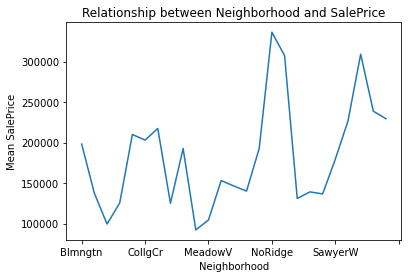

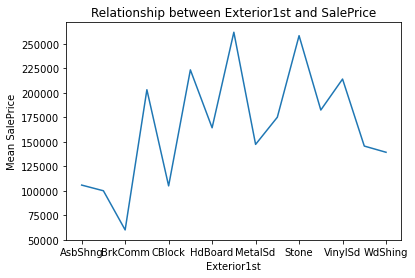

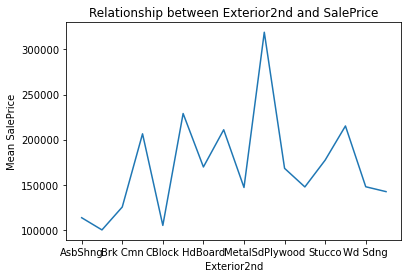

In [74]:
# let's explore the relationship of the categories with the target

for var in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['SalePrice'].mean().plot()
    fig.set_title('Relationship between {} and SalePrice'.format(var))
    fig.set_ylabel('Mean SalePrice')
    plt.show()

You can see that the relationship between the target and the categories of the categorical variables goes up and down, depending on the category.


## Ordered Integer encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the encoding maps separately if planing to use them in production.

In [75]:
# let's order the labels according to the mean target value

X_train.groupby(['Neighborhood'])['SalePrice'].mean().sort_values()

Neighborhood
IDOTRR      92174.166667
BrDale      99440.000000
MeadowV    104441.666667
Edwards    125082.676056
BrkSide    125438.414634
OldTown    130958.328767
Sawyer     136596.442623
Blueste    137500.000000
SWISU      139154.666667
NPkVill    140107.142857
NAmes      146435.264901
Mitchel    153070.444444
SawyerW    179463.088889
Gilbert    192662.290909
NWAmes     192788.235294
Blmngtn    198164.500000
CollgCr    203086.371429
ClearCr    210034.666667
Crawfor    217453.914286
Somerst    226644.196429
Veenker    229500.000000
Timber     238700.100000
NridgHt    307418.137255
StoneBr    309105.937500
NoRidge    336264.666667
Name: SalePrice, dtype: float64

In the above cell, we ordered the categories from the neighbourhood where the houses sale prices are cheaper (IDOTRR), to the neighbourhood where the house prices are, on average, more expensive (NoRidge).

In the next cells, we will replace those categories, ordered as they are, by the numbers 0 to k, where k is the number of different categories minus 1, in this case 25 - 1 = 24.

So IDOTRR will be replaced by 0 and NoRidge by 24, just to be clear.

In [76]:
# first  we generate an ordered list with the labels

ordered_labels = X_train.groupby(['Neighborhood'
                                  ])['SalePrice'].mean().sort_values().index

ordered_labels

Index(['IDOTRR', 'BrDale', 'MeadowV', 'Edwards', 'BrkSide', 'OldTown',
       'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel', 'SawyerW',
       'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor',
       'Somerst', 'Veenker', 'Timber', 'NridgHt', 'StoneBr', 'NoRidge'],
      dtype='object', name='Neighborhood')

In [77]:
# next let's create a dictionary with the mappings of categories to numbers

ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}

ordinal_mapping

{'IDOTRR': 0,
 'BrDale': 1,
 'MeadowV': 2,
 'Edwards': 3,
 'BrkSide': 4,
 'OldTown': 5,
 'Sawyer': 6,
 'Blueste': 7,
 'SWISU': 8,
 'NPkVill': 9,
 'NAmes': 10,
 'Mitchel': 11,
 'SawyerW': 12,
 'Gilbert': 13,
 'NWAmes': 14,
 'Blmngtn': 15,
 'CollgCr': 16,
 'ClearCr': 17,
 'Crawfor': 18,
 'Somerst': 19,
 'Veenker': 20,
 'Timber': 21,
 'NridgHt': 22,
 'StoneBr': 23,
 'NoRidge': 24}

In [78]:
# now, we replace the labels with the integers

X_train['Neighborhood'] = X_train['Neighborhood'].map(ordinal_mapping)
X_test['Neighborhood'] = X_test['Neighborhood'].map(ordinal_mapping)

In [79]:
# let's explore the result

X_train['Neighborhood'].head(10)

64      16
682     17
960      4
1384     3
1100     8
416      6
1034    18
853     10
472      3
1011     3
Name: Neighborhood, dtype: int64

In [80]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = df.groupby([variable])[target].mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [81]:
# and now we run a loop over the remaining categorical variables

for variable in ['Exterior1st', 'Exterior2nd']:

    mappings = find_category_mappings(X_train, variable, 'SalePrice')

    integer_encode(X_train, X_test, variable, mappings)

In [82]:
# let's see the result

X_train.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
64,16,11,13,219500
682,17,5,7,173000
960,4,5,8,116500
1384,3,4,4,105000
1100,8,5,7,60000


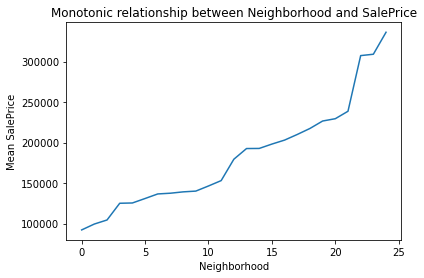

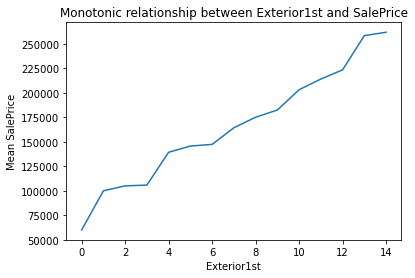

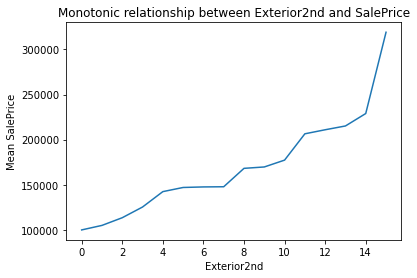

In [83]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['SalePrice'].mean().plot()
    fig.set_title('Monotonic relationship between {} and SalePrice'.format(var))
    fig.set_ylabel('Mean SalePrice')
    plt.show()

We see from the plots above that the relationship between the categories and the target is now monotonic, and for the first 2 variables, almost linear, which helps improve linear models performance.

### Note

Monotonic does not mean strictly linear. Monotonic means that it increases constantly, or it decreases constantly.

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

## Integer Encoding with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

In [84]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Neighborhood', 'Exterior1st', 'Exterior2nd']], # predictors
    data['SalePrice'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [85]:
ordinal_enc = OrdinalEncoder(
    # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
    encoding_method='ordered',
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])

In [86]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

ordinal_enc.fit(X_train, y_train)

OrdinalEncoder(variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])

In [87]:
# in the encoder dict we can observe each of the top categories
# selected for each of the variables

ordinal_enc.encoder_dict_

{'Neighborhood': {'IDOTRR': 0,
  'BrDale': 1,
  'MeadowV': 2,
  'Edwards': 3,
  'BrkSide': 4,
  'OldTown': 5,
  'Sawyer': 6,
  'Blueste': 7,
  'SWISU': 8,
  'NPkVill': 9,
  'NAmes': 10,
  'Mitchel': 11,
  'SawyerW': 12,
  'Gilbert': 13,
  'NWAmes': 14,
  'Blmngtn': 15,
  'CollgCr': 16,
  'ClearCr': 17,
  'Crawfor': 18,
  'Somerst': 19,
  'Veenker': 20,
  'Timber': 21,
  'NridgHt': 22,
  'StoneBr': 23,
  'NoRidge': 24},
 'Exterior1st': {'BrkComm': 0,
  'AsphShn': 1,
  'CBlock': 2,
  'AsbShng': 3,
  'WdShing': 4,
  'Wd Sdng': 5,
  'MetalSd': 6,
  'HdBoard': 7,
  'Plywood': 8,
  'Stucco': 9,
  'BrkFace': 10,
  'VinylSd': 11,
  'CemntBd': 12,
  'Stone': 13,
  'ImStucc': 14},
 'Exterior2nd': {'AsphShn': 0,
  'CBlock': 1,
  'AsbShng': 2,
  'Brk Cmn': 3,
  'Wd Shng': 4,
  'MetalSd': 5,
  'Stone': 6,
  'Wd Sdng': 7,
  'Plywood': 8,
  'HdBoard': 9,
  'Stucco': 10,
  'BrkFace': 11,
  'ImStucc': 12,
  'VinylSd': 13,
  'CmentBd': 14,
  'Other': 15}}

In [88]:
# this is the list of variables that the encoder will transform

ordinal_enc.variables_

['Neighborhood', 'Exterior1st', 'Exterior2nd']

In [89]:
X_train = ordinal_enc.transform(X_train)
X_test = ordinal_enc.transform(X_test)

# let's explore the result
X_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,16,11,13
682,17,5,7
960,4,5,8
1384,3,4,4
1100,8,5,7


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

Finally, if there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.

<a id = "6"></a><br>
# 6 - Mean Encoding

In the previous lectures in this section, we learned how to convert a label into a number, by using one hot encoding, replacing by a digit or replacing by frequency or counts of observations. These methods are simple, make (almost) no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the target mean (mean encoding / target encoding)
- Replacing the labels by the probability ratio of the target being 1 or 0
- Weight of evidence.

All of the above methods have something in common:

- the encoding is **guided by the target**, and
- they create a **monotonic relationship** between the variable and the target.


### Monotonicity

A monotonic relationship is a relationship that does one of the following:

- (1) as the value of one variable increases, so does the value of the other variable; or
- (2) as the value of one variable increases, the value of the other variable decreases.

In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target value decreases.



### Advantages of target guided encodings

- Capture information within the category, therefore creating more predictive features
- Create a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


### Limitations

- Prone to cause over-fitting
- Difficult to cross-validate with current libraries


### Note

The methods discussed in this and the coming 3 lectures can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".

===============================================================================

## Mean Encoding or Target Encoding

Mean encoding implies replacing the category by the average target value for that category. For example, if we have the variable city, with categories London, Manchester and Bristol, and we want to predict the default rate, if the default rate for London is 30% we replace London by 0.3, if the default rate for Manchester is 20% we replace Manchester by 0.2 and so on.


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine

And the advantages and limitations of each implementation using the Titanic dataset.

In [92]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import MeanEncoder

In [93]:
# load dataset

data = pd.read_csv(
    'titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [94]:
# let's fill na in embarked

data['embarked'].fillna('Missing', inplace=True)

In [95]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [96]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  9  labels
embarked :  4  labels


In [97]:
# let's explore the unique categories

data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'T', 'F', 'G'], dtype=object)

In [98]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [99]:
data['embarked'].unique()

array(['S', 'C', 'Missing', 'Q'], dtype=object)

### Encoding important

We calculate the target mean per category using the train set, and then use those mappings in the test set.

Note that for the pandas implementation we need to keep the target in the training set:

In [100]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 4), (393, 4))

### Explore original relationship between categorical variables and target

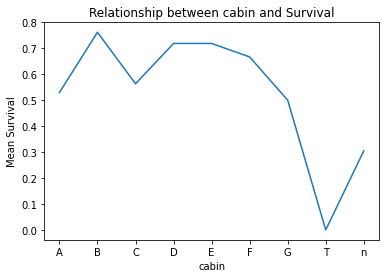

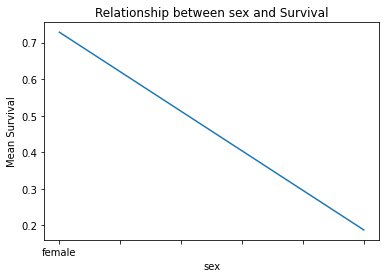

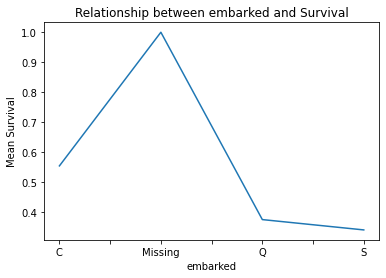

In [101]:
# let's explore the relationship of the categories with the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Mean encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [102]:
# let's calculate the mean target value per category for cabin

X_train.groupby(['cabin'])['survived'].mean()

cabin
A    0.529412
B    0.761905
C    0.563380
D    0.718750
E    0.718750
F    0.666667
G    0.500000
T    0.000000
n    0.304843
Name: survived, dtype: float64

In [103]:
# and now let's do the same but capturing the result in a dictionary

ordered_labels = X_train.groupby(['cabin'])['survived'].mean().to_dict()

ordered_labels

{'A': 0.5294117647058824,
 'B': 0.7619047619047619,
 'C': 0.5633802816901409,
 'D': 0.71875,
 'E': 0.71875,
 'F': 0.6666666666666666,
 'G': 0.5,
 'T': 0.0,
 'n': 0.30484330484330485}

In [104]:
# now, we replace the labels with the target means

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [105]:
# let's explore the result

X_train['cabin'].head(10)

501     0.304843
588     0.304843
402     0.304843
1193    0.304843
686     0.304843
971     0.304843
117     0.718750
540     0.304843
294     0.563380
261     0.718750
Name: cabin, dtype: float64

In [106]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):
    return df.groupby([variable])[target].mean().to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [107]:
# and now we run a loop over the remaining categorical variables

for variable in ['sex', 'embarked']:
    mappings = find_category_mappings(X_train, variable, 'survived')
    integer_encode(X_train, X_test, variable, mappings)

In [108]:
# let's see the result

X_train.head()

,cabin,sex,embarked,survived
501,0.304843,0.728358,0.338957,1
588,0.304843,0.728358,0.338957,1
402,0.304843,0.728358,0.553073,1
1193,0.304843,0.187608,0.373494,0
686,0.304843,0.728358,0.373494,1


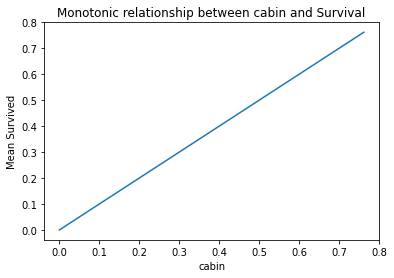

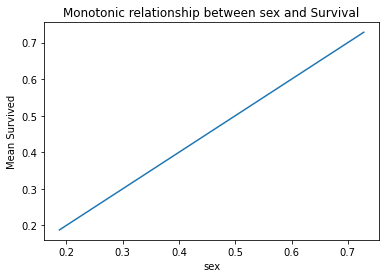

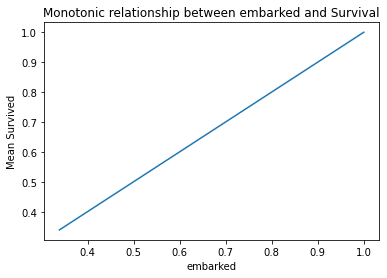

In [109]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Mean Encoding creates linear relationships between the mean target and the categories.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

## Mean Encoding with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

In [110]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 3), (393, 3))

In [111]:
mean_enc = MeanEncoder(
    variables=['cabin', 'sex', 'embarked'])

In [112]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

mean_enc.fit(X_train, y_train)

MeanEncoder(variables=['cabin', 'sex', 'embarked'])

In [113]:
# in the encoder dict we see the target mean assigned to each
# category for each of the selected variables

mean_enc.encoder_dict_

{'cabin': {'A': 0.5294117647058824,
  'B': 0.7619047619047619,
  'C': 0.5633802816901409,
  'D': 0.71875,
  'E': 0.71875,
  'F': 0.6666666666666666,
  'G': 0.5,
  'T': 0.0,
  'n': 0.30484330484330485},
 'sex': {'female': 0.7283582089552239, 'male': 0.18760757314974183},
 'embarked': {'C': 0.553072625698324,
  'Missing': 1.0,
  'Q': 0.37349397590361444,
  'S': 0.3389570552147239}}

In [114]:
# this is the list of variables that the encoder will transform

mean_enc.variables_

['cabin', 'sex', 'embarked']

In [115]:
X_train = mean_enc.transform(X_train)
X_test = mean_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
501,0.304843,0.728358,0.338957
588,0.304843,0.728358,0.338957
402,0.304843,0.728358,0.553073
1193,0.304843,0.187608,0.373494
686,0.304843,0.728358,0.373494


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

Finally, if there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.

<a id = "7"></a><br>
# 7 - Probability-Ratio-Encoding

In the previous lectures in this section, we learned how to convert a label into a number, by using one hot encoding, replacing by a digit or replacing by frequency or counts of observations. These methods are simple, make (almost) no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the target mean (mean encoding / target encoding)
- Replacing the labels by the probability ratio of the target being 1 or 0
- Weight of evidence.

All of the above methods have something in common:

- the encoding is **guided by the target**, and
- they create a **monotonic relationship** between the variable and the target.


### Monotonicity

A monotonic relationship is a relationship that does one of the following:

- (1) as the value of one variable increases, so does the value of the other variable; or
- (2) as the value of one variable increases, the value of the other variable decreases.

In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target value decreases.



### Advantages of target guided encodings

- Capture information within the category, therefore creating more predictive features
- Create a monotonic relationship between the variable and the target, therefore suitable for linear models
- Do not expand the feature space


### Limitations

- Prone to cause over-fitting
- Difficult to cross-validate with current libraries


### Note

The methods discussed in this and the coming 3 lectures can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".

===============================================================================

## Probability Ratio Encoding

These encoding is suitable for classification problems only, where the target is binary.

For each category, we calculate the mean of target=1, that is the probability of the target being 1 ( P(1) ), and the probability of the target=0 ( P(0) ). And then, we calculate the ratio P(1)/P(0), and replace the categories by that ratio.


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine

And the advantages and limitations of each implementation using the Titanic dataset.

In [116]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding with feature-engine
from feature_engine.encoding import PRatioEncoder

In [118]:
# load dataset

data = pd.read_csv(
    'titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [119]:
# let's remove obserrvations with na in embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [120]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [121]:
# and we remove the observations where cabin = T
# because they are too few

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [122]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  8  labels
embarked :  3  labels


In [123]:
# let's explore the unique categories
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [124]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [125]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Encoding important

We calculate the ratio  P(1)/P(0) using the train set, and then use those mappings in the test set.

Note that to implement this in pandas, we need to keep the target in the training set.

In [126]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Explore original relationship between categorical variables and target

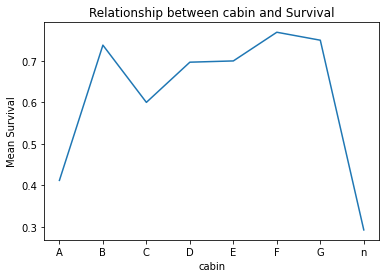

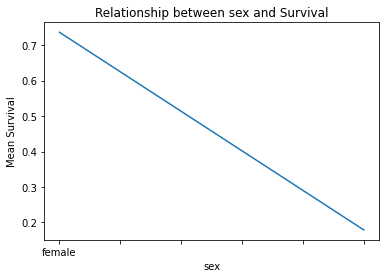

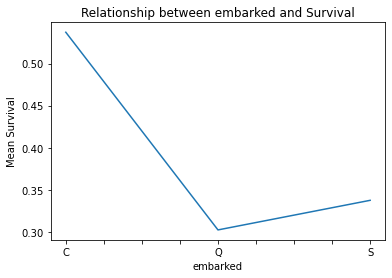

In [127]:
# let's explore the relationship of the categories with the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Probability ratio encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

In [128]:
# let's calculate the probability of survived = 1 per category

prob_df = X_train.groupby(['cabin'])['survived'].mean()

# and capture it into a dataframe
prob_df = pd.DataFrame(prob_df)
prob_df

,survived
cabin,
A,0.411765
B,0.738095
C,0.600000
D,0.696970
E,0.700000
F,0.769231
G,0.750000
n,0.292199


In [129]:
# and now the probability of survived = 0

prob_df['died'] = 1 - prob_df['survived']

prob_df

,survived,died
cabin,,
A,0.411765,0.588235
B,0.738095,0.261905
C,0.600000,0.400000
D,0.696970,0.303030
E,0.700000,0.300000
F,0.769231,0.230769
G,0.750000,0.250000
n,0.292199,0.707801


In [130]:
#  and now the ratio

prob_df['ratio'] = prob_df['survived'] / prob_df['died']

prob_df

,survived,died,ratio
cabin,,,
A,0.411765,0.588235,0.700000
B,0.738095,0.261905,2.818182
C,0.600000,0.400000,1.500000
D,0.696970,0.303030,2.300000
E,0.700000,0.300000,2.333333
F,0.769231,0.230769,3.333333
G,0.750000,0.250000,3.000000
n,0.292199,0.707801,0.412826


In [131]:
# and now let's capture the ratio in a dictionary

ordered_labels = prob_df['ratio'].to_dict()

ordered_labels

{'A': 0.7,
 'B': 2.818181818181819,
 'C': 1.4999999999999998,
 'D': 2.3000000000000007,
 'E': 2.333333333333333,
 'F': 3.333333333333334,
 'G': 3.0,
 'n': 0.4128256513026052}

In [132]:
# now, we replace the labels with the ratios

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [133]:
# let's explore the result

X_train['cabin'].head(10)

843     0.412826
869     0.412826
430     0.412826
481     0.412826
1308    0.412826
456     0.412826
118     2.300000
485     2.300000
297     0.412826
263     2.333333
Name: cabin, dtype: float64

In [134]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):

    tmp = pd.DataFrame(df.groupby([variable])[target].mean())
    
    tmp['non-target'] = 1 - tmp[target]
    
    tmp['ratio'] = tmp[target] / tmp['non-target']

    return tmp['ratio'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [135]:
# and now we run a loop over the remaining categorical variables

for variable in ['sex', 'embarked']:
    
    mappings = find_category_mappings(X_train, variable, 'survived')
    
    integer_encode(X_train, X_test, variable, mappings)

In [136]:
# let's see the result

X_train.head()

,cabin,sex,embarked,survived
843,0.412826,0.218107,0.509434,0
869,0.412826,0.218107,0.509434,0
430,0.412826,2.788235,0.509434,1
481,0.412826,2.788235,1.160920,1
1308,0.412826,0.218107,0.509434,0


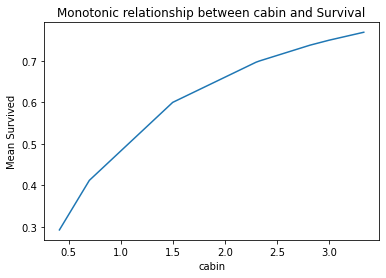

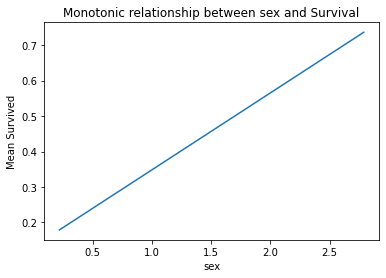

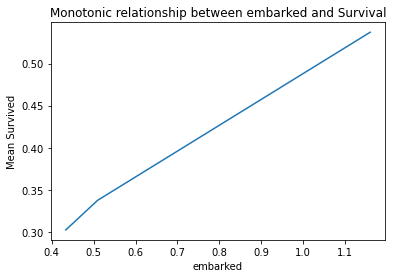

In [137]:
# let's inspect the newly created monotonic relationship
# between the categorical variables and the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Note the monotonic relationships between the mean target and the categories.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

**In addition, it will create NA or Inf if the probability of target = 0 is zero, as the division by zero is not defined.**

## Probability Ratio Encoding with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

In [138]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']], # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 3), (392, 3))

In [139]:
ratio_enc = PRatioEncoder(
    encoding_method = 'ratio',
    variables=['cabin', 'sex', 'embarked'])

In [140]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

ratio_enc.fit(X_train, y_train)

PRatioEncoder(variables=['cabin', 'sex', 'embarked'])

In [141]:
# in the encoder dict we see the P(1)/P(0) for each
# category for each of the indicated variables

ratio_enc.encoder_dict_

{'cabin': {'A': 0.7,
  'B': 2.818181818181819,
  'C': 1.4999999999999998,
  'D': 2.3000000000000007,
  'E': 2.333333333333333,
  'F': 3.333333333333334,
  'G': 3.0,
  'n': 0.4128256513026052},
 'sex': {'female': 2.788235294117647, 'male': 0.21810699588477367},
 'embarked': {'C': 1.160919540229885,
  'Q': 0.4333333333333333,
  'S': 0.5094339622641509}}

In [142]:
# this is the list of variables that the encoder will transform

ratio_enc.variables_

['cabin', 'sex', 'embarked']

In [143]:
X_train = ratio_enc.transform(X_train)
X_test = ratio_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
843,0.412826,0.218107,0.509434
869,0.412826,0.218107,0.509434
430,0.412826,2.788235,0.509434
481,0.412826,2.788235,1.160920
1308,0.412826,0.218107,0.509434


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

If there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.

Finally, if the probability of target = 0 is zero for any category, the encoder will raise an error as the division by zero is not defined.

<a id = "8"></a><br>
# 8 - Weight  of Evidence

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

- WoE will be 0 if the P(Goods) / P(Bads) = 1, that is, if the outcome is random for that group.
- If P(Bads) > P(Goods) the odds ratio will be < 1 and,
- WoE will be < 0 if,  P(Goods) > P(Bads).

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It creates a monotonic relationship between the target and the independent variables.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has a limitation:

- Prone to cause over-fitting


For more details follow this [article](https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#Steps-of-Calculating-WOE) and this [article](https://blogs.oracle.com/r/computing-weight-of-evidence-woe-and-information-value-iv).


## In this demo:

We will see how to perform one hot encoding with:
- pandas
- Feature-Engine
- Category encoders

And the advantages and limitations of each implementation using the Titanic dataset.

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# for encoding using feature-engine
from feature_engine.encoding import WoEEncoder as fe_WoEEncoder
from category_encoders.woe import WOEEncoder

In [10]:
# load dataset

data = pd.read_csv(
    'titanic.csv',
    usecols=['cabin', 'sex', 'embarked', 'survived'])

data.head()

,survived,sex,cabin,embarked
0,1,female,B5,S
1,1,male,C22,S
2,0,female,C22,S
3,0,male,C22,S
4,0,female,C22,S


In [11]:
# let's remove observations with na in embarked

data.dropna(subset=['embarked'], inplace=True)
data.shape

(1307, 4)

In [12]:
# Now we extract the first letter of the cabin
# to create a simpler variable for the demo

data['cabin'] = data['cabin'].astype(str).str[0]

In [13]:
# and we remove the observations where cabin = T
# because only few observations show T in the dataset

data = data[data['cabin']!= 'T']
data.shape

(1306, 4)

In [14]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(col, ': ', len(data[col].unique()), ' labels')

survived :  2  labels
sex :  2  labels
cabin :  8  labels
embarked :  3  labels


In [16]:
# let's explore the unique categories
data['cabin'].unique()

array(['B', 'C', 'E', 'D', 'A', 'n', 'F', 'G'], dtype=object)

In [17]:
data['sex'].unique()

array(['female', 'male'], dtype=object)

In [18]:
data['embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

### Encoding important

We select calculate the woe using the train set, and then use those mappings in the test set.

Note that in the pandas implementation, we need to keep the target in the training set

In [19]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked', 'survived']],  # this time we keep the target!!
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 4), (392, 4))

### Explore original relationship between categorical variables and target

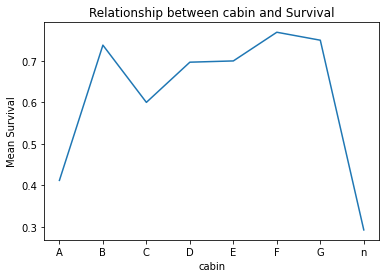

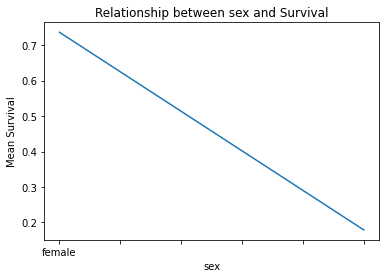

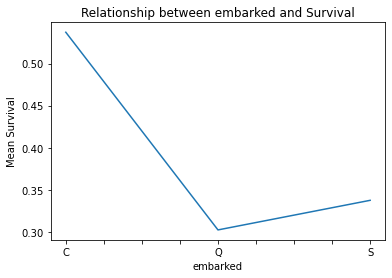

In [20]:
# let's explore the relationship of the categories with the target

for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survival')
    plt.show()

You can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.


## Weight of Evidence with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the mappings separately if planning to use the model in production.

In [23]:
# let's calculate the proportion of passengers who survived
# over the total survivors, per category of cabin

# total survivors
total_survived = X_train['survived'].sum()

# percentage of passenges who survived, from total survivors
# per category of cabin
survived = X_train.groupby(['cabin'])['survived'].sum() / total_survived

survived

cabin
A    0.020408
B    0.090379
C    0.122449
D    0.067055
E    0.061224
F    0.029155
G    0.008746
n    0.600583
Name: survived, dtype: float64

In [24]:
# let's calculate the proportion of passengers who did not survive
# over the total passengers who didn't, per category of cabin

# total passengers who did not survive
total_non_survived = len(X_train) - X_train['survived'].sum()

# let's create a flag for passenges who did not survive
X_train['non_survived'] = np.where(X_train['survived'] == 1, 0, 1)

# now let's calculate the % of passengers who did not survive
# per category of cabin
non_survived = X_train.groupby(
    ['cabin'])['non_survived'].sum() / total_non_survived

non_survived

cabin
A    0.017513
B    0.019264
C    0.049037
D    0.017513
E    0.015762
F    0.005254
G    0.001751
n    0.873905
Name: non_survived, dtype: float64

In [25]:
#  now let's combine those 2 series in a dataframe and calculate the
# WoE

# let's concatenate the series in a dataframe
prob_df = pd.concat([survived, non_survived], axis=1)

# let's calculate the Weight of Evidence
prob_df['woe'] = np.log(prob_df['survived']/prob_df['non_survived'])

prob_df

,survived,non_survived,woe
cabin,,,
A,0.020408,0.017513,0.152984
B,0.090379,0.019264,1.545751
C,0.122449,0.049037,0.915124
D,0.067055,0.017513,1.342568
E,0.061224,0.015762,1.356957
F,0.029155,0.005254,1.713632
G,0.008746,0.001751,1.608271
n,0.600583,0.873905,-0.375071


In [26]:
# and now let's capture the woe in a dictionary

ordered_labels = prob_df['woe'].to_dict()

ordered_labels

{'A': 0.1529838185513379,
 'B': 1.545750694176846,
 'C': 0.9151238705982346,
 'D': 1.3425678854251744,
 'E': 1.356956622877274,
 'F': 1.7136315668160063,
 'G': 1.60827105115818,
 'n': -0.37507116447186734}

In [27]:
# now, we replace the labels with the woe

X_train['cabin'] = X_train['cabin'].map(ordered_labels)
X_test['cabin'] = X_test['cabin'].map(ordered_labels)

In [28]:
# let's explore the result

X_train['cabin'].head(10)

843    -0.375071
869    -0.375071
430    -0.375071
481    -0.375071
1308   -0.375071
456    -0.375071
118     1.342568
485     1.342568
297    -0.375071
263     1.356957
Name: cabin, dtype: float64

In [29]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):

    # copy of the original dataframe, so we do not accidentally
    # modify it
    tmp = df.copy()

    # total positive class
    total_pos = df[target].sum()

    # total negative class
    total_neg = len(df) - df[target].sum()

    # non target
    tmp['non-target'] = 1 - tmp[target]

    # % of positive class per category, respect to total positive class
    pos_perc = tmp.groupby([variable])[target].sum() / total_pos

    # % of negative class per category, respect to total negative class
    neg_perc = tmp.groupby([variable])['non-target'].sum() / total_neg

    # let's concatenate
    prob_tmp = pd.concat([pos_perc, neg_perc], axis=1)

    # let's calculate the Weight of Evidence
    prob_tmp['woe'] = np.log(prob_tmp[target]/prob_tmp['non-target'])

    return prob_tmp['woe'].to_dict()


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)

    test[variable] = test[variable].map(ordinal_mapping)

In [30]:
# and now we run a loop over the remaining categorical variables

for variable in ['sex', 'embarked']:

    mappings = find_category_mappings(X_train, variable, 'survived')

    integer_encode(X_train, X_test, variable, mappings)

In [31]:
# let's see the result

X_train.head()

,cabin,sex,embarked,survived,non_survived
843,-0.375071,-1.013111,-0.164796,0,1
869,-0.375071,-1.013111,-0.164796,0,1
430,-0.375071,1.535068,-0.164796,1,0
481,-0.375071,1.535068,0.658871,1,0
1308,-0.375071,-1.013111,-0.164796,0,1


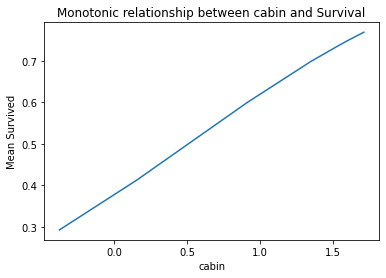

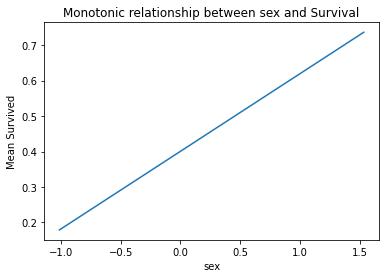

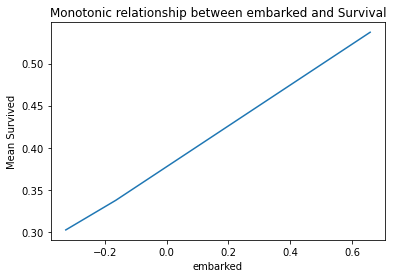

In [32]:
# let's inspect the newly created monotonic relationship
# between the categorical variables and the target

# first in the train set
for var in ['cabin', 'sex', 'embarked']:

    fig = plt.figure()
    fig = X_train.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

Note the monotonic relationships between the mean target and the categories. In the train set.

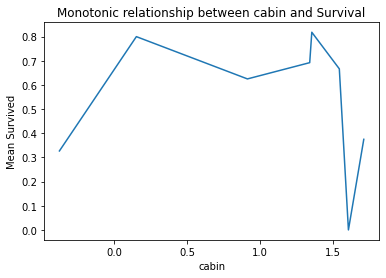

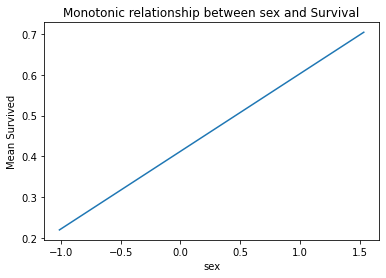

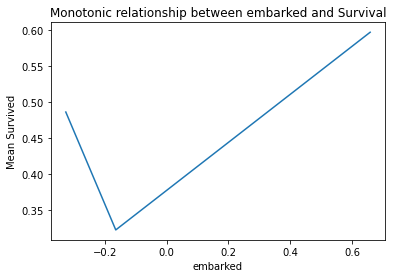

In [166]:
# now in the test set
for var in ['cabin', 'sex', 'embarked']:
    
    fig = plt.figure()
    fig = X_test.groupby([var])['survived'].mean().plot()
    fig.set_title('Monotonic relationship between {} and Survival'.format(var))
    fig.set_ylabel('Mean Survived')
    plt.show()

The monotonic relationship does not hold when encoding the categorical variables in the test set. This could mean that the categories are not informative of the target or the proportion of survivors is not homogeneous between in the categories in the train and test sets. 

In situations like this, we could try grouping rare labels into a joint category as we will cover later in this section, before applying the Weight of evidence transformation.

### Note

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. I will explain how to do this, in a later notebook.

**In addition, it will create NA or Inf if any of the 2 terms in the ratio of the WoE formula are 0**

## Weight of Evidence with Feature-Engine

If using Feature-Engine, instead of pandas, we do not need to keep the target variable in the training dataset.

In [167]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 3), (392, 3))

In [168]:
woe_enc = fe_WoEEncoder(variables=['cabin', 'sex', 'embarked'])

In [169]:
# when fitting the transformer, we need to pass the target as well
# just like with any Scikit-learn predictor class

woe_enc.fit(X_train, y_train)

WoEEncoder(variables=['cabin', 'sex', 'embarked'])

In [170]:
# in the encoder dict we see the woe for each category
# for each of the selected variables

woe_enc.encoder_dict_

{'cabin': {'A': 0.1529838185513379,
  'B': 1.545750694176846,
  'C': 0.9151238705982346,
  'D': 1.3425678854251744,
  'E': 1.356956622877274,
  'F': 1.7136315668160063,
  'G': 1.60827105115818,
  'n': -0.37507116447186734},
 'sex': {'female': 1.535067647134885, 'male': -1.0131107672983564},
 'embarked': {'C': 0.658871160676746,
  'Q': -0.3265892617105483,
  'S': -0.16479628505772237}}

In [171]:
# this is the list of variables that the encoder will transform

woe_enc.variables_

['cabin', 'sex', 'embarked']

In [172]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
843,-0.375071,-1.013111,-0.164796
869,-0.375071,-1.013111,-0.164796
430,-0.375071,1.535068,-0.164796
481,-0.375071,1.535068,0.658871
1308,-0.375071,-1.013111,-0.164796


**Note**

If the argument variables is left to None, then the encoder will automatically identify all categorical variables. Is that not sweet?

The encoder will not encode numerical variables. So if some of your numerical variables are in fact categories, you will need to re-cast them as object before using the encoder.

If there is a label in the test set that was not present in the train set, the encoder will through and error, to alert you of this behaviour.

Finally, if any of the terms in the weight of evidence calculation is 0, the log of 0 is not defined, so this transformer will raise an error.

## Weight of Evidence with Category Encoders

If using Category encpders, instead of pandas, we do not need to keep the target variable in the training dataset.

In [173]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['cabin', 'sex', 'embarked']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((914, 3), (392, 3))

In [174]:
woe_enc = WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [175]:
woe_enc.fit(X_train, y_train)

WOEEncoder(cols=['cabin', 'sex', 'embarked'])

In [176]:
# the mappings in category encoders are not so easy to interpret

woe_enc.mapping

{'cabin': cabin
  1   -0.374548
  2    1.287500
  3    1.295799
  4    0.901246
  5    1.518942
  6    0.188888
  7    1.488171
  8    1.200488
 -1    0.000000
 -2    0.000000
 dtype: float64,
 'sex': sex
  1   -1.008094
  2    1.525265
 -1    0.000000
 -2    0.000000
 dtype: float64,
 'embarked': embarked
  1   -0.164851
  2    0.654977
  3   -0.307696
 -1    0.000000
 -2    0.000000
 dtype: float64}

In [177]:
X_train = woe_enc.transform(X_train)
X_test = woe_enc.transform(X_test)

# let's explore the result
X_train.head()

,cabin,sex,embarked
843,-0.374548,-1.008094,-0.164851
869,-0.374548,-1.008094,-0.164851
430,-0.374548,1.525265,-0.164851
481,-0.374548,1.525265,0.654977
1308,-0.374548,-1.008094,-0.164851


<a id = "9"></a><br>
## Comparison of Categorical Variable Encodings

In this lecture, we will compare the performance of the different feature categorical encoding techniques we learned so far.

We will compare:

- One hot encoding
- Replacing labels by the count
- Ordering labels according to target
- Mean Encoding
- WoE

Using the titanic dataset

In [33]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score

In [35]:
# let's load the titanic dataset

# we will only use these columns in the demo
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare',
        'sex', 'cabin', 'embarked', 'survived']

data = pd.read_csv('titanic.csv', usecols=cols)

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22,S
2,1,0,female,2.0000,1,2,151.5500,C22,S
3,1,0,male,30.0000,1,2,151.5500,C22,S
4,1,0,female,25.0000,1,2,151.5500,C22,S


In [36]:
# let's check for missing data

data.isnull().sum()

pclass         0
survived       0
sex            0
age          263
sibsp          0
parch          0
fare           1
cabin       1014
embarked       2
dtype: int64

In [37]:
# Drop observations with NA in Fare and embarked

data.dropna(subset=['fare', 'embarked'], inplace=True)

In [38]:
# Now we extract the first letter of the cabin

data['cabin'] = data['cabin'].astype(str).str[0]

data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B,S
1,1,1,male,0.9167,1,2,151.5500,C,S
2,1,0,female,2.0000,1,2,151.5500,C,S
3,1,0,male,30.0000,1,2,151.5500,C,S
4,1,0,female,25.0000,1,2,151.5500,C,S


In [39]:
# drop observations with cabin = T, they are too few

data = data[data['cabin'] != 'T']

In [40]:
# Let's divide into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels='survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.3,
    random_state=0,
    stratify=data['survived']
    )

X_train.shape, X_test.shape

((913, 8), (392, 8))

In [41]:
# Let's replace null values in numerical variables by the mean


def impute_na(df, variable, value):
    df[variable].fillna(value, inplace=True)


impute_na(X_test, 'age', X_train['age'].mean())
impute_na(X_train, 'age',  X_train['age'].mean())
# note how I impute first the test set, this way the value of
# the median used will be the same for both train and test

In [42]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
390,2,male,17.000000,0,0,73.5000,n,S
8,1,female,53.000000,2,0,51.4792,C,S
218,1,female,39.000000,0,0,108.9000,C,C
1062,3,male,21.000000,0,0,7.8542,n,S
1255,3,male,29.919623,0,0,7.2292,n,C


In [43]:
# let's check that we have no missing data after NA imputation

X_train.isnull().sum(), X_test.isnull().sum()

(pclass      0
 sex         0
 age         0
 sibsp       0
 parch       0
 fare        0
 cabin       0
 embarked    0
 dtype: int64,
 pclass      0
 sex         0
 age         0
 sibsp       0
 parch       0
 fare        0
 cabin       0
 embarked    0
 dtype: int64)

### One Hot Encoding

In [44]:
def get_OHE(df):

    df_OHE = pd.concat(
        [df[['pclass', 'age', 'sibsp', 'parch', 'fare']],
         pd.get_dummies(df[['sex', 'cabin', 'embarked']], drop_first=True)],
        axis=1)

    return df_OHE


X_train_OHE = get_OHE(X_train)
X_test_OHE = get_OHE(X_test)

X_train_OHE.head()

,pclass,age,sibsp,parch,fare,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_n,embarked_Q,embarked_S
390,2,17.000000,0,0,73.5000,1,0,0,0,0,0,0,1,0,1
8,1,53.000000,2,0,51.4792,0,0,1,0,0,0,0,0,0,1
218,1,39.000000,0,0,108.9000,0,0,1,0,0,0,0,0,0,0
1062,3,21.000000,0,0,7.8542,1,0,0,0,0,0,0,1,0,1
1255,3,29.919623,0,0,7.2292,1,0,0,0,0,0,0,1,0,0


In [45]:
X_test_OHE.head()

,pclass,age,sibsp,parch,fare,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_n,embarked_Q,embarked_S
417,2,26.000000,0,0,10.5000,1,0,0,0,0,0,0,1,0,1
38,1,41.000000,0,0,30.5000,1,0,0,0,0,0,0,0,0,1
876,3,29.919623,0,0,7.8958,1,0,0,0,0,0,0,1,0,1
672,3,29.919623,0,0,7.2292,1,0,0,0,0,0,0,1,0,0
395,2,18.000000,0,1,23.0000,0,0,0,0,0,0,0,1,0,1


### Count encoding

In [46]:
def categorical_to_counts(df_train, df_test):

    # make a temporary copy of the original dataframes
    df_train_temp = df_train.copy()
    df_test_temp = df_test.copy()

    for col in ['sex', 'cabin', 'embarked']:

        # make dictionary mapping category to counts
        counts_map = df_train_temp[col].value_counts().to_dict()

        # remap the labels to their counts
        df_train_temp[col] = df_train_temp[col].map(counts_map)
        df_test_temp[col] = df_test_temp[col].map(counts_map)

    return df_train_temp, df_test_temp


X_train_count, X_test_count = categorical_to_counts(X_train, X_test)

X_train_count.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
390,2,586,17.000000,0,0,73.5000,709,636
8,1,327,53.000000,2,0,51.4792,61,636
218,1,327,39.000000,0,0,108.9000,61,195
1062,3,586,21.000000,0,0,7.8542,709,636
1255,3,586,29.919623,0,0,7.2292,709,195


### Ordered Integer Encoding

In [47]:
def categories_to_ordered(df_train, df_test, y_train, y_test):

    # make a temporary copy of the datasets
    df_train_temp = pd.concat([df_train, y_train], axis=1).copy()
    df_test_temp = pd.concat([df_test, y_test], axis=1).copy()

    for col in ['sex', 'cabin', 'embarked']:

        # order categories according to target mean
        ordered_labels = df_train_temp.groupby(
            [col])['survived'].mean().sort_values().index

        # create the dictionary to map the ordered labels to an ordinal number
        ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

        # remap the categories  to these ordinal numbers
        df_train_temp[col] = df_train[col].map(ordinal_label)
        df_test_temp[col] = df_test[col].map(ordinal_label)

    # remove the target
    df_train_temp.drop(['survived'], axis=1, inplace=True)
    df_test_temp.drop(['survived'], axis=1, inplace=True)

    return df_train_temp, df_test_temp


X_train_ordered, X_test_ordered = categories_to_ordered(
    X_train, X_test, y_train, y_test)

X_train_ordered.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
390,2,0,17.000000,0,0,73.5000,0,1
8,1,1,53.000000,2,0,51.4792,2,1
218,1,1,39.000000,0,0,108.9000,2,2
1062,3,0,21.000000,0,0,7.8542,0,1
1255,3,0,29.919623,0,0,7.2292,0,2


### Mean Encoding

In [48]:
def categories_to_mean(df_train, df_test, y_train, y_test):

    # make a temporary copy of the datasets
    df_train_temp = pd.concat([df_train, y_train], axis=1).copy()
    df_test_temp = pd.concat([df_test, y_test], axis=1).copy()

    for col in ['sex', 'cabin', 'embarked']:

        # calculate mean target per category
        ordered_labels = df_train_temp.groupby(
            [col])['survived'].mean().to_dict()

        # remap the categories to target mean
        df_train_temp[col] = df_train[col].map(ordered_labels)
        df_test_temp[col] = df_test[col].map(ordered_labels)

    # remove the target
    df_train_temp.drop(['survived'], axis=1, inplace=True)
    df_test_temp.drop(['survived'], axis=1, inplace=True)

    return df_train_temp, df_test_temp


X_train_mean, X_test_mean = categories_to_mean(
    X_train, X_test, y_train, y_test)

X_train_mean.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
390,2,0.182594,17.000000,0,0,73.5000,0.303244,0.334906
8,1,0.737003,53.000000,2,0,51.4792,0.573770,0.334906
218,1,0.737003,39.000000,0,0,108.9000,0.573770,0.553846
1062,3,0.182594,21.000000,0,0,7.8542,0.303244,0.334906
1255,3,0.182594,29.919623,0,0,7.2292,0.303244,0.553846


### Probability Ratio

In [49]:
def categories_to_ratio(df_train, df_test, y_train, y_test):

    # make a temporary copy of the datasets
    df_train_temp = pd.concat([df_train, y_train], axis=1).copy()
    df_test_temp = pd.concat([df_test, y_test], axis=1).copy()

    for col in ['sex', 'cabin', 'embarked']:

        # create df containing the different parts of the WoE equation
        # prob survived =1
        prob_df = pd.DataFrame(df_train_temp.groupby([col])['survived'].mean())

        # prob survived = 0
        prob_df['died'] = 1-prob_df.survived

        # calculate WoE
        prob_df['Ratio'] = np.log(prob_df.survived/prob_df.died)

        # capture woe in dictionary
        woe = prob_df['Ratio'].to_dict()

        # re-map the labels to WoE
        df_train_temp[col] = df_train[col].map(woe)
        df_test_temp[col] = df_test[col].map(woe)

    # drop the target
    df_train_temp.drop(['survived'], axis=1, inplace=True)
    df_test_temp.drop(['survived'], axis=1, inplace=True)

    return df_train_temp, df_test_temp


X_train_ratio, X_test_ratio = categories_to_ratio(X_train, X_test, y_train, y_test)

X_train_ratio.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked
390,2,-1.498872,17.000000,0,0,73.5000,-0.831897,-0.686080
8,1,1.030450,53.000000,2,0,51.4792,0.297252,-0.686080
218,1,1.030450,39.000000,0,0,108.9000,0.297252,0.216223
1062,3,-1.498872,21.000000,0,0,7.8542,-0.831897,-0.686080
1255,3,-1.498872,29.919623,0,0,7.2292,-0.831897,0.216223


### Random Forest Performance

In [50]:
# create a function to build random forests and compare performance in train and test set


def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=50, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [51]:
# OHE
run_randomForests(X_train_OHE, X_test_OHE, y_train, y_test)

Train set
Random Forests roc-auc: 0.8471467805920048
Test set
Random Forests roc-auc: 0.8100413223140497


In [52]:
# counts
run_randomForests(X_train_count, X_test_count, y_train, y_test)

Train set
Random Forests roc-auc: 0.8664861153494049
Test set
Random Forests roc-auc: 0.8198484848484847


In [53]:
# ordered labels
run_randomForests(X_train_ordered, X_test_ordered, y_train, y_test)

Train set
Random Forests roc-auc: 0.8671218594242701
Test set
Random Forests roc-auc: 0.8151239669421488


In [54]:
# mean encoding
run_randomForests(X_train_mean, X_test_mean, y_train, y_test)

Train set
Random Forests roc-auc: 0.8670862577560776
Test set
Random Forests roc-auc: 0.8150413223140497


In [55]:
# ratio
run_randomForests(X_train_ratio, X_test_ratio, y_train, y_test)

Train set
Random Forests roc-auc: 0.8670862577560776
Test set
Random Forests roc-auc: 0.8150413223140497


Comparing the roc_auc values on the test sets, we can see that one hot encoding has the worse performance. This makes sense because trees do not perform well in datasets with big feature spaces.

The remaining encodings returned similar performances. This also makes sense, because trees are non-linear models, so target guided encodings may not necessarily improve the model performance

### Logistic Regression Performance

In [58]:
def run_logistic(X_train, X_test, y_train, y_test):

    # function to train and test the performance of logistic regression
    logit = LogisticRegression(random_state=44, C=0.01, max_iter=100)
    logit.fit(X_train, y_train)

    print('Train set')
    pred = logit.predict_proba(X_train)
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = logit.predict_proba(X_test)
    print(
        'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

In [59]:
# OHE
run_logistic(X_train_OHE, X_test_OHE, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8270725256840605
Test set
Logistic Regression roc-auc: 0.8038154269972452


In [60]:
# counts
run_logistic(X_train_count, X_test_count, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8046943342488049
Test set
Logistic Regression roc-auc: 0.7563498622589532


c:\Users\abdul.meral\Anaconda3\envs\tensorflow_torch\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [61]:
# ordered labels
run_logistic(X_train_ordered, X_test_ordered, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8225765435866138
Test set
Logistic Regression roc-auc: 0.7967906336088153


In [62]:
# mean encoding
run_logistic(X_train_mean, X_test_mean, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.7784355609805717
Test set
Logistic Regression roc-auc: 0.7580578512396694


In [63]:
# ratio
run_logistic(X_train_ratio, X_test_ratio, y_train, y_test)

Train set
Logistic Regression roc-auc: 0.8506357440748652
Test set
Logistic Regression roc-auc: 0.8177272727272726


For Logistic regression, the best performances are obtained with one hot encoding, as it preserves linear relationships with variables and target, and also with weight of evidence, and ordered encoding.

Note however how count encoding, returns the worse performance as it does not create a monotonic relationship between variables and target, and in this case, mean target encoding is probably causing over-fitting.

<a id = "10"></a><br>
## Engineering Rare Categories

Rare values are categories within a categorical variable that are present only in a small percentage of the observations. There is no rule of thumb to determine how small is a small percentage, but typically, any value below 5 % can be considered rare.

As we discussed in section 3 of the course, Infrequent labels are so few, that it is hard to derive reliable information from them. But more importantly, if you remember from section 3, infrequent labels tend to appear only on train set or only on the test set:

- If only on the train set, they may cause over-fitting
- If only on the test set, our machine learning model will not know how to score them

Therefore, to avoid this behaviour, we tend to group those into a new category called 'Rare' or 'Other'.

Rare labels can appear in low or highly cardinal variables. There is no rule of thumb to determine how many different labels are considered high cardinality. It depend as well on how many observations there are in the dataset. In a dataset with 1,000 observations, 100 labels may seem a lot, whereas in a dataset with 100,000 observations it may not be so high.

Highly cardinal variables tend to have many infrequent or rare categories, whereas low cardinal variables, may have only 1 or 2 rare labels.

### Note the following:

**Note that grouping infrequent labels or categories under a new category called 'Rare' or 'Other' is the common practice in machine learning for business.**

- Grouping categories into rare for variables that show low cardinality may or may not improve model performance, however, we tend to re-group them into a new category to smooth model deployment.

- Grouping categories into rare for variables with high cardinality, tends to improve model performance as well.


## In this demo:

We will learn how to re-group rare labels under a new category called rare, and compare the implications of this encoding in variables with:

- One predominant category
- A small number of categories
- High cardinality

For this demo, we will use the House Sale dataset. We will re-group variables using pandas an feature-engine.

In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None) # to display the total number columns present in the dataset

## House Sale Price dataset

In [65]:
# let's load the house price dataset

data = pd.read_csv('houseprice.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Important

The identification of rare labels should be done using only the training set, and then propagated to the test set. Rare labels should be identified in the training set only. In practice, what we will do is identify **non-rare labels**, and then any other label, either in the train or the test or future live data that is not in that list of **non-rare** labels, will be re=grouped into the new category.

For example, let's imagine that we have in the training set the variable 'city' with the labels 'London', 'Manchester' and 'Yorkshire'. 'Yorkshire' is present in less than 5% of the observations so we decide to re-group it in a new category called 'Rare'.

In the test set, we should also replace 'Yorkshire' by 'Rare', regardless of the percentage of observations for 'Yorkshire' in the test set. In addition, if in the test set we find the category 'Milton Keynes', that was not present in the training set, we should also replace that category by 'Rare'. On other words, all categories present in test set, not present in the list of **non-rare** categories derived from the training set, should be treated as rare values and re-grouped into 'Rare'.

In [67]:
# let's divide into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1), # predictors
    data.SalePrice, # target
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 80), (438, 80))

## Variables with one dominant category

In [68]:
# let's explore a few examples in which variables have only a few categories, say less than 3

for col in X_train.columns:
    
    if X_train[col].dtypes == 'O':  # if the variable is categorical
        
        if X_train[col].nunique() < 3:  # if the variable has less than 3 categories
            
            # print percentage of observations per category
            print(X_train.groupby(col)[col].count() / len(X_train))
            print()

Street
Grvl    0.004892
Pave    0.995108
Name: Street, dtype: float64

Alley
Grvl    0.029354
Pave    0.031311
Name: Alley, dtype: float64

Utilities
AllPub    0.999022
NoSeWa    0.000978
Name: Utilities, dtype: float64

CentralAir
N    0.068493
Y    0.931507
Name: CentralAir, dtype: float64

PoolQC
Ex    0.000978
Gd    0.001957
Name: PoolQC, dtype: float64



### Conclusion

The 3 variables above, Street, Utilities and CentralAir, show one dominating category which accounts for more than 93-99% of the observations. Re-grouping the rare label in this situation does not make any sense. We could determine if these variables are useful with exploratory analysis, or any feature selection algorithm, or drop the variables altogether.

## Variables with few categories

In [69]:
# the columns in the below list have only 4 different labels

cols = ['MasVnrType', 'ExterQual', 'BsmtCond']

for col in cols:
    
    print(X_train.groupby(col)[col].count() / len(X_train)) # frequency
    print()

MasVnrType
BrkCmn     0.009785
BrkFace    0.294521
None       0.595890
Stone      0.094912
Name: MasVnrType, dtype: float64

ExterQual
Ex    0.029354
Fa    0.011742
Gd    0.332681
TA    0.626223
Name: ExterQual, dtype: float64

BsmtCond
Fa    0.032290
Gd    0.045010
Po    0.001957
TA    0.897260
Name: BsmtCond, dtype: float64



The variables above have only 4 categories, and in all three cases, there is at least one category that is infrequent, that is, that is present in less than 5% of the observations.

When the variable has only a few categories, then perhaps it makes no sense to re-categorise the rare labels into something else.

For example the first variable MasVnrType shows only 1 rare label, BrkCmn. Thus, re-categorising it into a new label will leave the variable in the same situation.

The second variable ExterQual, contains 2 rare labels Ex and Fa, we could group these 2 into a new label called 'Rare'.

The third variable BsmtCond contains 3 rare labels, Fa, Gd and Po, so we could group these 3 under the new label 'Rare'.

## Variable with high cardinality

In [70]:
# let's explore examples in which variables have several categories, say more than 10

multi_cat_cols = []

for col in X_train.columns:

    if X_train[col].dtypes =='O': # if variable  is categorical
    
        if X_train[col].nunique() > 10: # and has more than 10 categories
            
            multi_cat_cols.append(col)  # add to the list
            
            print(X_train.groupby(col)[col].count()/ len(X_train)) # and print the percentage of observations within each category
            
            print()

Neighborhood
Blmngtn    0.011742
Blueste    0.001957
BrDale     0.009785
BrkSide    0.040117
ClearCr    0.023483
CollgCr    0.102740
Crawfor    0.034247
Edwards    0.069472
Gilbert    0.053816
IDOTRR     0.023483
MeadowV    0.011742
Mitchel    0.035225
NAmes      0.147750
NPkVill    0.006849
NWAmes     0.049902
NoRidge    0.029354
NridgHt    0.049902
OldTown    0.071429
SWISU      0.017613
Sawyer     0.059687
SawyerW    0.044031
Somerst    0.054795
StoneBr    0.015656
Timber     0.029354
Veenker    0.005871
Name: Neighborhood, dtype: float64

Exterior1st
AsbShng    0.014677
AsphShn    0.000978
BrkComm    0.000978
BrkFace    0.034247
CBlock     0.000978
CemntBd    0.038160
HdBoard    0.149706
ImStucc    0.000978
MetalSd    0.135029
Plywood    0.084149
Stone      0.001957
Stucco     0.016634
VinylSd    0.356164
Wd Sdng    0.144814
WdShing    0.020548
Name: Exterior1st, dtype: float64

Exterior2nd
AsbShng    0.016634
AsphShn    0.000978
Brk Cmn    0.003914
BrkFace    0.017613
CBlock     0

We can see that many categories are rare in the 3 categorical variables printed above. In fact, we can plot them using the same code we learned in the lecture on rare labels in section 3:

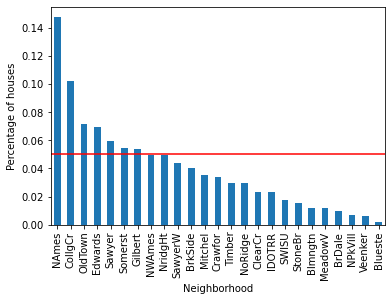

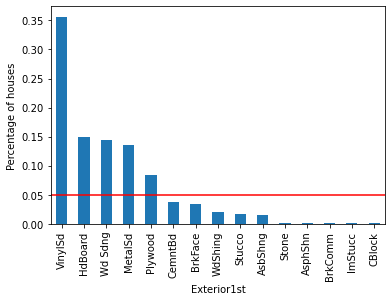

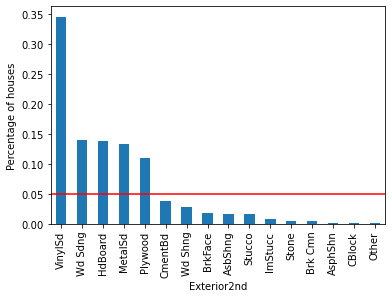

In [71]:
for col in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

## Re-grouping rare labels with pandas

In [72]:
def find_non_rare_labels(df, variable, tolerance):
    
    temp = df.groupby([variable])[variable].count() / len(df)
    
    non_rare = [x for x in temp.loc[temp>tolerance].index.values]
    
    return non_rare

In [73]:
# non rare labels
find_non_rare_labels(X_train, 'Neighborhood', 0.05)

['CollgCr', 'Edwards', 'Gilbert', 'NAmes', 'OldTown', 'Sawyer', 'Somerst']

In [74]:
# rare labels

[x for x in X_train['Neighborhood'].unique(
) if x not in find_non_rare_labels(X_train, 'Neighborhood', 0.05)]

['ClearCr',
 'BrkSide',
 'SWISU',
 'Crawfor',
 'Mitchel',
 'Timber',
 'MeadowV',
 'BrDale',
 'NWAmes',
 'NridgHt',
 'SawyerW',
 'NoRidge',
 'IDOTRR',
 'NPkVill',
 'StoneBr',
 'Blmngtn',
 'Veenker',
 'Blueste']

In [75]:
def rare_encoding(X_train, X_test, variable, tolerance):

    X_train = X_train.copy()
    X_test = X_test.copy()

    # find the most frequent category
    frequent_cat = find_non_rare_labels(X_train, variable, tolerance)

    # re-group rare labels
    X_train[variable] = np.where(X_train[variable].isin(
        frequent_cat), X_train[variable], 'Rare')
    
    X_test[variable] = np.where(X_test[variable].isin(
        frequent_cat), X_test[variable], 'Rare')

    return X_train, X_test

In [76]:
for variable in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:
    
    X_train, X_test = rare_encoding(X_train, X_test, variable, 0.05)

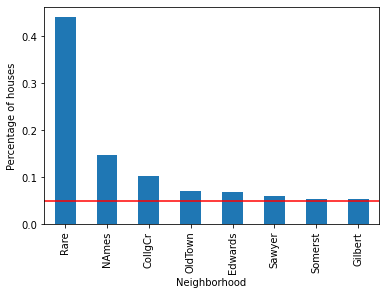

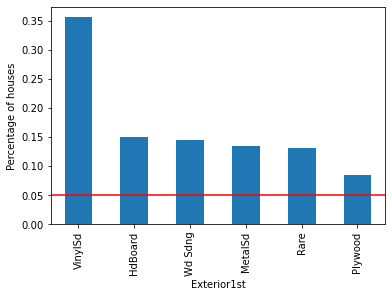

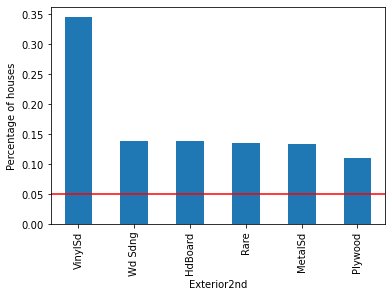

In [77]:
for col in ['Neighborhood', 'Exterior1st', 'Exterior2nd']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()

And now let's encode the low cardinal variables.

In [78]:
for variable in ['MasVnrType', 'ExterQual', 'BsmtCond']:
    
    X_train, X_test = rare_encoding(X_train, X_test, variable, 0.05)

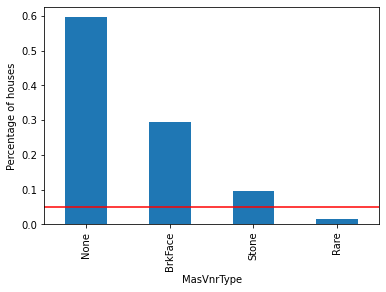

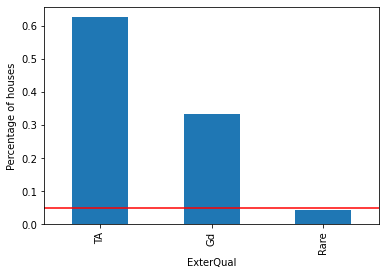

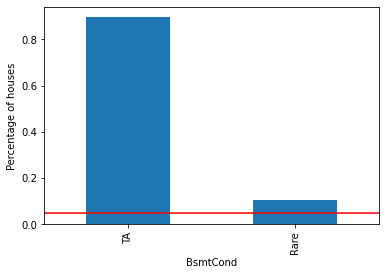

In [79]:
for col in ['MasVnrType', 'ExterQual', 'BsmtCond']:

    temp_df = pd.Series(X_train[col].value_counts() / len(X_train) )

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of houses')
    plt.show()